In [1]:
import numpy as np
import illustris_python as il
from pathlib import Path

In [ ]:


basePath = Path("../sims.TNG/TNG50-1/output")
snap = 99
sid = 646733  # Subfind subhalo ID

sh = il.groupcat.loadSingle(str(basePath), snap, subhaloID=sid)

# Now this exists for subhalos
J = np.array(sh["SubhaloSpin"], dtype=float)

J_norm = np.linalg.norm(J)
if J_norm > 0:
    inc = np.degrees(np.arccos(np.clip(abs(J[2]) / J_norm, 0, 1)))
    PA  = np.degrees(np.arctan2(J[1], J[0])) % 180.0
    print(f"Subhalo {sid}: inclination = {inc:.1f} deg, PA = {PA:.1f} deg")
else:
    print(f"Subhalo {sid}: spin vector is zero or undefined.")

Subhalo 646733: inclination = 30.4 deg, PA = 101.7 deg


In [65]:
import numpy as np
import pandas as pd
import illustris_python as il
import os

# ---------------- CONFIG ----------------
basePath = "../sims.TNG/TNG50-1/output"  # <-- change to your path
snap = 99
OBS_CSV = "COS_GASS_TNG50_matches_index.csv"
out_dir = "tng_inclinations_from_groupcat"
os.makedirs(out_dir, exist_ok=True)

# ---------------- HELPER FUNCTIONS ----------------
def inc_PA_from_vector(J):
    """Return (inclination_deg, PA_deg, |J|) from a 3-vector J."""
    J = np.asarray(J, float)
    if J.shape != (3,) or not np.isfinite(J).all():
        return np.nan, np.nan, np.nan
    Jn = np.linalg.norm(J)
    if Jn == 0:
        return np.nan, np.nan, 0.0
    inc = np.degrees(np.arccos(np.clip(abs(J[2]) / Jn, 0, 1)))  # 0° face-on, 90° edge-on
    n = np.cross([0, 0, 1.0], J / Jn)
    PA = 0.0 if np.hypot(n[0], n[1]) < 1e-14 else (np.degrees(np.arctan2(n[1], n[0])) % 180.0)
    return inc, PA, Jn

# ---------------- LOAD CSV ----------------
df = pd.read_csv(OBS_CSV)
df["SubhaloID"] = df["SubhaloID"].astype(int)

unique_sids = np.unique(df["SubhaloID"])
print(f"Unique Subhalos to process: {len(unique_sids)}")

# ---------------- COMPUTE ORIENTATIONS ----------------
results = []
try:
    spins = il.groupcat.loadSubhalos(str(basePath), snap, fields=["SubhaloSpin"])
    allJ = np.asarray(spins["SubhaloSpin"])
    max_sid = len(allJ) - 1
    for sid in unique_sids:
        if sid > max_sid:
            results.append({"SubhaloID": sid, "status": "sid_out_of_range"})
            continue
        J = allJ[sid]
        inc, PA, Jn = inc_PA_from_vector(J)
        results.append({
            "SubhaloID": sid, "status": "ok",
            "Jx": J[0], "Jy": J[1], "Jz": J[2],
            "Jnorm": Jn, "inc_deg": inc, "PA_deg": PA
        })
except Exception as e:
    print("Vectorized load failed, using loadSingle(...). Reason:", e)
    for sid in unique_sids:
        sh = il.groupcat.loadSingle(str(basePath), snap, subhaloID=int(sid))
        if sh is None or "SubhaloSpin" not in sh:
            results.append({"SubhaloID": sid, "status": "no_SubhaloSpin"})
            continue
        J = np.asarray(sh["SubhaloSpin"], float)
        inc, PA, Jn = inc_PA_from_vector(J)
        results.append({
            "SubhaloID": sid, "status": "ok",
            "Jx": J[0], "Jy": J[1], "Jz": J[2],
            "Jnorm": Jn, "inc_deg": inc, "PA_deg": PA
        })

spin_df = pd.DataFrame(results)
print("Computed orientations for", (spin_df["status"] == "ok").sum(), "/", len(spin_df))

# ---------------- MERGE BACK ----------------
df_with_orient = df.merge(spin_df, on="SubhaloID", how="left")

# ---------------- SAVE ----------------
out_file = os.path.join(out_dir, f"COS_GASS_TNG50_with_orientations_snap{snap}.csv")
df_with_orient.to_csv(out_file, index=False)
print(f"Saved results to: {out_file}")

# Quick peek
display(df_with_orient.head(10))

Unique Subhalos to process: 50
Vectorized load failed, using loadSingle(...). Reason: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Computed orientations for 50 / 50
Saved results to: tng_inclinations_from_groupcat/COS_GASS_TNG50_with_orientations_snap99.csv


,COS_ID,Galaxy,MatchRank,SubhaloID,GroupID,dlogMstar,dlogMHI,dist,status,Jx,Jy,Jz,Jnorm,inc_deg,PA_deg
0,1,J0159+1346,1,618120,548,0.001419,0.007362,0.006386,ok,-61.454056,497.809723,149.826752,523.487513,73.368880,7.037495
1,1,J0159+1346,2,630870,637,0.000174,0.017211,0.014198,ok,-219.994858,-101.459732,-140.812805,280.214312,59.833254,114.758744
2,1,J0159+1346,3,553231,260,0.018750,0.006297,0.026644,ok,-180.041153,269.023743,184.304230,372.500523,60.345035,33.791977
3,3,J0852+0309,1,607530,487,0.008237,0.035000,0.031067,ok,-560.448425,-521.756653,121.434837,775.292759,80.988602,132.952392
4,3,J0852+0309,2,579232,348,0.015784,0.032578,0.034727,ok,1069.742798,-337.293365,-5.637558,1121.672078,89.712028,72.499768
5,3,J0852+0309,3,545003,236,0.026029,0.004921,0.036503,ok,-1110.074585,-235.310913,-307.868469,1175.763498,74.820400,101.968257
6,5,J0914+0836,1,606038,479,0.001019,0.013989,0.011625,ok,-560.926025,468.068878,912.798401,1169.156705,38.672327,50.156441
7,5,J0914+0836,2,549091,248,0.002192,0.084553,0.069807,ok,29.718977,-86.317642,57.938667,108.124198,57.598227,18.998474
8,5,J0914+0836,3,622877,579,0.049780,0.042027,0.077557,ok,155.158279,43.212818,240.306046,289.289535,33.831696,105.562944
9,10,J0951 + 3537,1,400974,50,0.010264,0.011894,0.017346,ok,577.848999,104.177933,-446.675659,737.754466,52.738553,100.219831


[INFO] Subhalo 491426 | N=1459042 | inc = 89.61 deg, PA = 69.84 deg
[CHECK] (R_edge @ Jhat) ~ [-8.54449939e-17  1.00000000e+00 -5.84386360e-19]   (should be ~ [0,1,0])


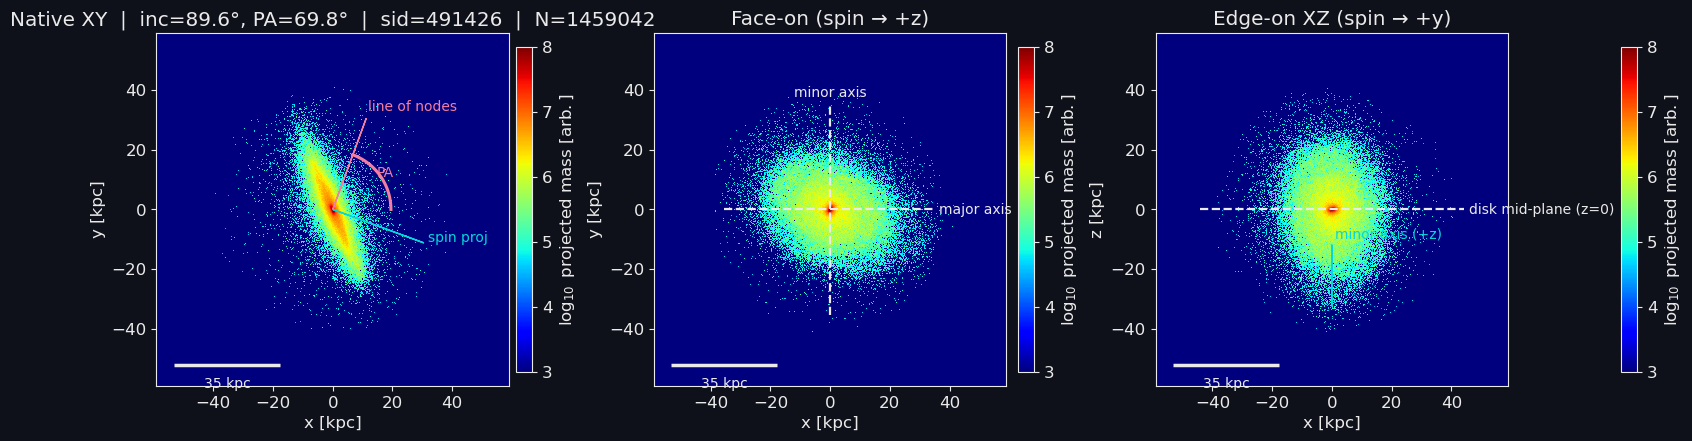

[SAVED] tng_orientation_checks/check_sid491426_part-stars_snap99.png


In [47]:
import os
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il

# =========================
# USER CONFIG
# =========================
basePath = "../sims.TNG/TNG50-1/output"   # <- EDIT
snap     = 99
sid      = 491426                         # <- subhalo to inspect
part     = "stars"                        # "stars" or "gas"  (gas selects SFR>0 if present)

extent_kpc_h = 80.0                       # FoV width (kpc/h); code converts to kpc using h
nbin         = 1200                        # pixels per side

use_rhalf_aperture = True
rhalf_multiplier   = 5.0

dpi_out        = 100
cmap_name      = "jet"                    # your choice
bg_color       = "#0f111a"
fg_color       = "#eaeaea"
spin_color     = "#06d7d9"
nodes_color    = "#f37ea1"
axes_guide     = "#eaeaea"
scalebar_color = "#eaeaea"

mpl.rcParams.update({
    "figure.facecolor": bg_color,
    "axes.facecolor":   bg_color,
    "savefig.facecolor": bg_color,
    "axes.edgecolor":   fg_color,
    "axes.labelcolor":  fg_color,
    "xtick.color":      fg_color,
    "ytick.color":      fg_color,
    "text.color":       fg_color,
    "font.family":      "DejaVu Sans",
    "font.size":        12,
})

# =========================
# Helpers
# =========================
def minimal_image_delta(dpos, box):
    return (dpos + 0.5*box) % box - 0.5*box

def recenter_positions(x, center, box):
    return minimal_image_delta(x - center[None,:], box)

def unit(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def inc_PA_from_vector(J):
    J = np.asarray(J, float)
    Jn = np.linalg.norm(J)
    if Jn == 0:
        return np.nan, np.nan
    Jhat = J / Jn
    inc = np.degrees(np.arccos(np.clip(abs(Jhat[2]), 0, 1)))  # 0 face-on, 90 edge-on
    n = np.cross([0,0,1.0], Jhat)         # line of nodes in XY
    PA = 0.0 if np.hypot(n[0], n[1]) < 1e-14 else (np.degrees(np.arctan2(n[1], n[0])) % 180.0)
    return inc, PA

def rotation_matrix_from_u_to_v(u, v):
    """
    Active rotation mapping u -> v (both 3-vectors).
    Returns 3x3 R so that R @ u == v.
    """
    u = np.asarray(u, float); u /= np.linalg.norm(u)
    v = np.asarray(v, float); v /= np.linalg.norm(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))             # cos θ
    if c > 1 - 1e-12:
        return np.eye(3)                                     # no rotation
    if c < -1 + 1e-12:
        # 180°: pick any axis orthogonal to u
        a = np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0])
        a /= np.linalg.norm(a)
        # rotation by π around a
        K = np.array([[0,-a[2],a[1]],
                      [a[2],0,-a[0]],
                      [-a[1],a[0],0]])
        return np.eye(3) + 2*(K @ K)                         # since sinπ=0, 1-cosπ=2
    # general case
    a = np.cross(u, v)
    s = float(np.linalg.norm(a))                              # sin θ
    a /= s                                                    # unit axis
    K = np.array([[0,-a[2],a[1]],
                  [a[2],0,-a[0]],
                  [-a[1],a[0],0]])
    # Rodrigues (no division by s**2!)
    R = np.eye(3) + K*s + (K @ K)*(1 - c)
    return R

def draw_scale_bar(ax, half_width_kpc, frac=0.3, ypad_frac=0.06, color="w", lw=2.5):
    L = half_width_kpc
    full = 2*L
    bar_len = frac * full
    x0 = -L + 0.05*full
    x1 = x0 + bar_len
    y  = -L + ypad_frac*full
    ax.plot([x0, x1], [y, y], color=color, lw=lw, solid_capstyle="butt")
    ax.text((x0+x1)/2, y - 0.035*full, f"{bar_len:.0f} kpc", color=color, ha="center", va="top", fontsize=10)

def draw_angle_arc(ax, radius, theta1_deg, theta2_deg, color="w", lw=2.0, nseg=100):
    t1 = np.radians(theta1_deg)
    t2 = np.radians(theta2_deg)
    ts = np.linspace(t1, t2, nseg)
    xs = radius*np.cos(ts)
    ys = radius*np.sin(ts)
    ax.plot(xs, ys, color=color, lw=lw)

def mass_map_arbitrary(M_weights, XY_kpc, half_width_kpc, nbin):
    L = half_width_kpc
    x = np.clip(XY_kpc[:,0], -L, L)
    y = np.clip(XY_kpc[:,1], -L, L)
    H, xe, ye = np.histogram2d(x, y, bins=nbin, range=[[-L, L], [-L, L]], weights=M_weights)
    return H.T, xe, ye, (2*L)/nbin

# =========================
# LOAD + SELECT
# =========================
gattrs = il.groupcat.loadHeader(str(basePath), snap)
box_ckpch = float(gattrs["BoxSize"])     # ckpc/h
h         = float(gattrs["HubbleParam"])

sh = il.groupcat.loadSingle(str(basePath), snap, subhaloID=sid)
if sh is None:
    raise RuntimeError(f"Could not load subhalo {sid}")
center_ckpch = np.array(sh["SubhaloPos"], float)
rhalf_star_ckpch = float(sh["SubhaloHalfmassRadType"][4])

fields = ["Coordinates","Masses","Velocities"]
if part == "gas":
    fields.append("StarFormationRate")
parts = il.snapshot.loadSubhalo(str(basePath), snap, sid, partType=part, fields=fields)
X_ckpch = np.asarray(parts["Coordinates"], float)
M_1e10Msun_h = np.asarray(parts["Masses"], float)
V_kms    = np.asarray(parts["Velocities"], float)

if part == "gas" and "StarFormationRate" in parts:
    sfr = np.asarray(parts["StarFormationRate"], float)
    good = sfr > 0
    X_ckpch, M_1e10Msun_h, V_kms = X_ckpch[good], M_1e10Msun_h[good], V_kms[good]

Xc_ckpch = recenter_positions(X_ckpch, center_ckpch, box_ckpch)

if use_rhalf_aperture and rhalf_star_ckpch > 0:
    R = np.linalg.norm(Xc_ckpch, axis=1)
    sel = R <= (rhalf_multiplier * rhalf_star_ckpch)
    if np.any(sel):
        Xc_ckpch, M_1e10Msun_h, V_kms = Xc_ckpch[sel], M_1e10Msun_h[sel], V_kms[sel]

Xc_kpc  = Xc_ckpch / h
M_msun  = M_1e10Msun_h * 1e10 / h
Npart   = len(M_msun)

J = np.array(sh["SubhaloSpin"], float)
# Alternatively:
# J = np.sum(np.cross(Xc_ckpch, V_kms) * M_1e10Msun_h[:,None], axis=0)

inc_deg, PA_deg = inc_PA_from_vector(J)
Jhat = unit(J)
print(f"[INFO] Subhalo {sid} | N={Npart} | inc = {inc_deg:.2f} deg, PA = {PA_deg:.2f} deg")

R_face = rotation_matrix_from_u_to_v(Jhat, np.array([0,0,1.0]))  # spin -> +z
R_edge = rotation_matrix_from_u_to_v(Jhat, np.array([0,1,0.0]))  # spin -> +y

# Sanity: rotated spin
J_edge = R_edge @ Jhat
print(f"[CHECK] (R_edge @ Jhat) ~ {J_edge}   (should be ~ [0,1,0])")

X_native_kpc = Xc_kpc
X_face_kpc   = (Xc_ckpch @ R_face.T) / h
X_edge_kpc   = (Xc_ckpch @ R_edge.T) / h

L_kpc = (extent_kpc_h / 2.0) / h

# NOTE: edge-on must use XZ plane (columns [0,2]), not XY
H_native, _, _, pix_native = mass_map_arbitrary(M_msun, X_native_kpc[:, [0,1]], L_kpc, nbin)  # XY
H_face,   _, _, pix_face   = mass_map_arbitrary(M_msun, X_face_kpc[:,   [0,1]], L_kpc, nbin)  # XY (spin->+z)
H_edge,   _, _, pix_edge   = mass_map_arbitrary(M_msun, X_edge_kpc[:,   [0,2]], L_kpc, nbin)  # XZ  <-- FIX

# =========================
# Annotations for native panel
# =========================
Jhat_xy = np.array([Jhat[0], Jhat[1]])
Jxy_n = np.linalg.norm(Jhat_xy)
if Jxy_n > 0:
    Jhat_xy /= Jxy_n
n_vec = np.cross([0,0,1.0], Jhat)         # line of nodes
nodes_xy = np.array([n_vec[0], n_vec[1]])
nxy_n = np.linalg.norm(nodes_xy)
if nxy_n > 0:
    nodes_xy /= nxy_n

PA_draw = None if nxy_n == 0 else (math.degrees(math.atan2(nodes_xy[1], nodes_xy[0])) % 360.0)

# =========================
# Plot
# =========================
fig, axs = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

VMIN = 3.0
VMAX = 8.0

def show_map(ax, H, title, xlabel="x [kpc]", ylabel="y [kpc]"):
    im = ax.imshow(
        np.log10(H + 1e-12),
        origin="lower",
        extent=[-L_kpc, L_kpc, -L_kpc, L_kpc],
        interpolation="nearest",
        cmap=cmap_name,
        vmin=VMIN, vmax=VMAX,
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    for spine in ax.spines.values():
        spine.set_edgecolor(fg_color)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label(r"$\log_{10}\ \mathrm{projected\ mass\ [arb.]}$")
    return ax

# Left: Native XY
title0 = f"Native XY  |  inc={inc_deg:.1f}°, PA={PA_deg:.1f}°  |  sid={sid}  |  N={Npart}"
ax0 = show_map(axs[0], H_native, title0, xlabel="x [kpc]", ylabel="y [kpc]")

if Jxy_n > 0:
    r0 = 0.55*L_kpc
    ax0.arrow(0, 0, r0*Jhat_xy[0], r0*Jhat_xy[1],
              width=0.0, head_width=0.9*pix_native, head_length=1.6*pix_native,
              color=spin_color, length_includes_head=True)
    ax0.text(r0*Jhat_xy[0]*1.05, r0*Jhat_xy[1]*1.05, "spin proj",
             color=spin_color, fontsize=10, ha="left", va="bottom")

if nxy_n > 0:
    r1 = 0.55*L_kpc
    ax0.arrow(0, 0, r1*nodes_xy[0], r1*nodes_xy[1],
              width=0.0, head_width=0.9*pix_native, head_length=1.6*pix_native,
              color=nodes_color, length_includes_head=True)
    ax0.text(r1*nodes_xy[0]*1.05, r1*nodes_xy[1]*1.05, "line of nodes",
             color=nodes_color, fontsize=10, ha="left", va="bottom")

if PA_draw is not None:
    draw_angle_arc(ax0, radius=0.33*L_kpc, theta1_deg=0.0, theta2_deg=PA_draw, color=nodes_color, lw=2.2)
    ax0.text(0.36*L_kpc*np.cos(np.radians(PA_draw/2)),
             0.36*L_kpc*np.sin(np.radians(PA_draw/2)),
             "PA", color=nodes_color, fontsize=10, ha="center", va="center")

draw_scale_bar(ax0, L_kpc, frac=0.3, color=scalebar_color)

# Middle: Face-on (spin -> +z), still XY plane
title1 = "Face-on (spin → +z)"
ax1 = show_map(axs[1], H_face, title1, xlabel="x [kpc]", ylabel="y [kpc]")
ax1.plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.6, ls='--')
ax1.plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.6, ls='--')
ax1.text(0.62*L_kpc, 0, "major axis", color=axes_guide, fontsize=10, va="center", ha="left")
ax1.text(0, 0.62*L_kpc, "minor axis", color=axes_guide, fontsize=10, va="bottom", ha="center")
draw_scale_bar(ax1, L_kpc, frac=0.3, color=scalebar_color)

# Right: Edge-on (spin → +y), show XZ plane (look along y)
title2 = "Edge-on XZ (spin → +y)"
ax2 = show_map(axs[2], H_edge, title2, xlabel="x [kpc]", ylabel="z [kpc]")
ax2.plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.6, ls='--')
ax2.text(0.78*L_kpc, 0, "disk mid-plane (z=0)", color=axes_guide, fontsize=10, va="center", ha="left")
# minor axis (+z) arrow
ax2.arrow(0, -0.55*L_kpc, 0, 0.35*L_kpc,
          width=0.0, head_width=0.9*pix_edge, head_length=1.6*pix_edge,
          color=spin_color, length_includes_head=True)
ax2.text(0.02*L_kpc, -0.18*L_kpc, "minor axis (+z)", color=spin_color, fontsize=10, va="bottom", ha="left")
draw_scale_bar(ax2, L_kpc, frac=0.3, color=scalebar_color)

outdir = "tng_orientation_checks"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, f"check_sid{sid}_part-{part}_snap{snap}.png")
plt.savefig(outfile, dpi=dpi_out)
plt.show()
print(f"[SAVED] {outfile}")

### Debugging for faw in Inc and PA calculation 

[INFO] Subhalo 491426 | N=1470782
  SubhaloSpin TOT    J = [1511.38781738 -554.96600342   10.90574455]   | inc=89.61°, PA=69.84°
  Stellar-only  J*   = [6424.72535735 2647.93530398 -660.84717432]    | inc=84.57°, PA=112.40°
  Angles between directions (deg):
    angle(J_tot,  J_star)  =  42.90
    angle(J_tot,  v3_pca)  =  42.34   (v3 ~ morphological normal)
    angle(J_star, v3_pca)  =   1.09
  2D PCA major-axis angle in XY (deg, from +x): 111.84 (expect ~ PA if inclined)
[RMS z] edge-on (SubhaloSpin) = 6.491 kpc
[RMS z] edge-on (stellar)     = 3.294 kpc
[RMS z] edge-on (PCA)         = 3.290 kpc


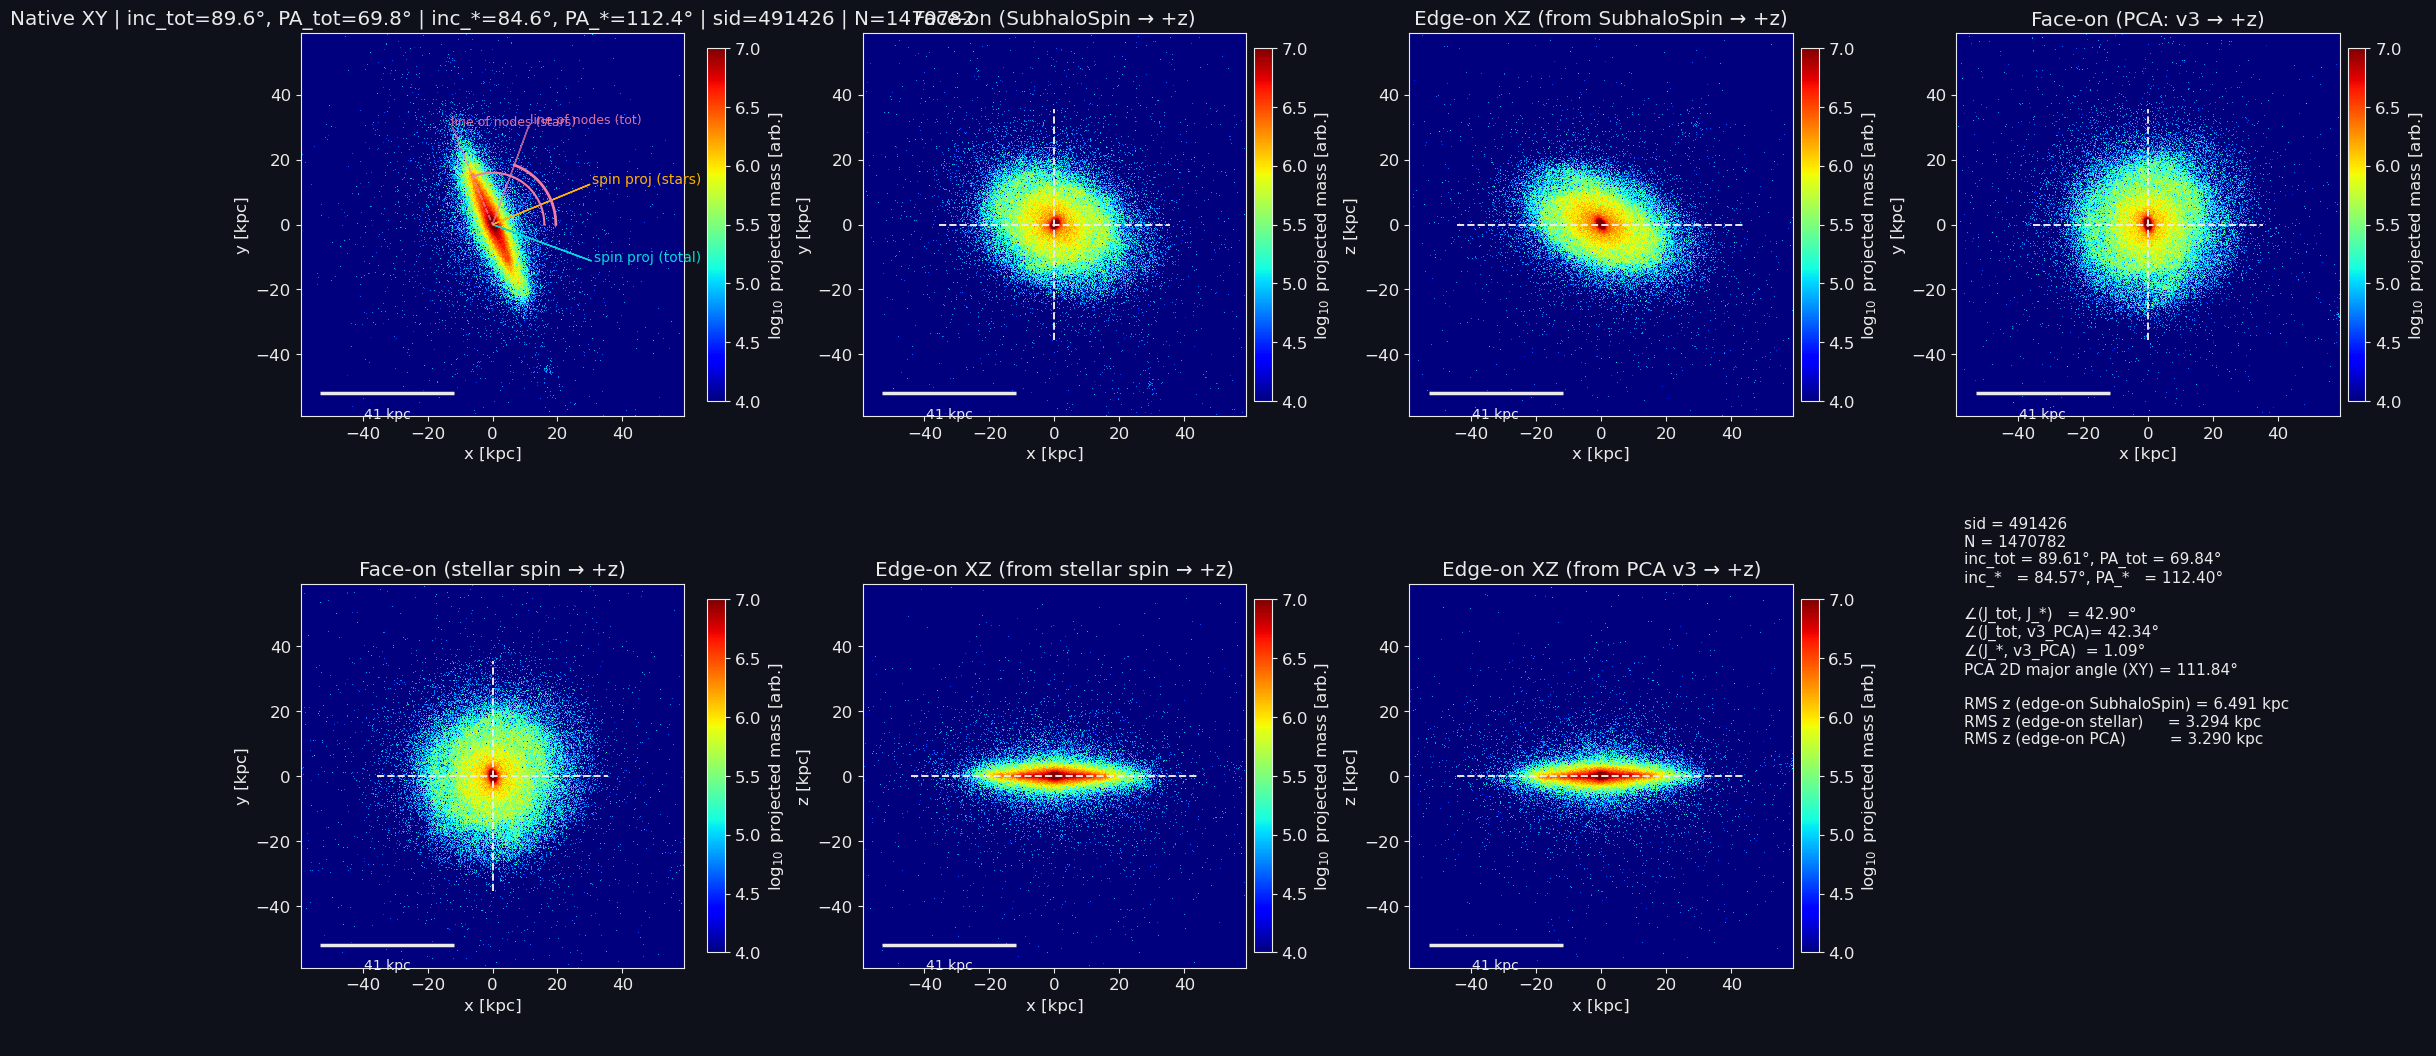

[SAVED] tng_orientation_checks_debug/debug_sid491426_part-stars_snap99.png


In [62]:
import os, math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il

# =========================
# USER CONFIG
# =========================
basePath = "../sims.TNG/TNG50-1/output"   # <- EDIT
snap     = 99
sid      =	491426                   # <- subhalo to inspect
part     = "stars"                        # "stars" or "gas"

# field-of-view width (kpc/h); code converts to kpc using h
extent_kpc_h = 80.0
nbin         = 1200

# aperture cut relative to stellar half-mass radius
use_rhalf_aperture = True
rhalf_multiplier   = 10.0

# set True to subtract stellar bulk velocity before stellar-spin calc
REMOVE_BULK_VEL = False

# figure / style
dpi_out        = 120
cmap_name      = "jet"                    # high-contrast, like your previous runs
bg_color       = "#0f111a"
fg_color       = "#eaeaea"
spin_tot_color = "#06d7d9"                # cyan (catalog SubhaloSpin)
spin_star_color= "#ffb000"                # orange (stellar-only spin)
nodes_color    = "#f37ea1"                # magenta (line of nodes / PA arc)
axes_guide     = "#eaeaea"
scalebar_color = "#eaeaea"

# color stretch in log10(arb) space
VMIN = 4.0
VMAX = 7.0

mpl.rcParams.update({
    "figure.facecolor": bg_color, "axes.facecolor": bg_color, "savefig.facecolor": bg_color,
    "axes.edgecolor": fg_color, "axes.labelcolor": fg_color, "xtick.color": fg_color,
    "ytick.color": fg_color, "text.color": fg_color, "font.family": "DejaVu Sans", "font.size": 12,
})

# =========================
# Helpers
# =========================
def minimal_image_delta(dpos, box): return (dpos + 0.5*box) % box - 0.5*box
def recenter_positions(x, center, box): return minimal_image_delta(x - center[None,:], box)

def unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def inc_PA_from_vector(J):
    """
    inc (deg): inclination wrt +z (0 face-on, 90 edge-on), uses |cos|.
    PA  (deg): position angle of line of nodes (z × J) in [0,180), measured from +x.
    """
    J = np.asarray(J, float); Jn = np.linalg.norm(J)
    if Jn == 0: return np.nan, np.nan
    Jhat = J / Jn
    inc = np.degrees(np.arccos(np.clip(abs(Jhat[2]), 0, 1)))
    n = np.cross([0,0,1.0], Jhat)
    PA = 0.0 if np.hypot(n[0], n[1]) < 1e-14 else (np.degrees(np.arctan2(n[1], n[0])) % 180.0)
    return inc, PA

def rodrigues_u_to_v(u, v):
    """Active rotation mapping u -> v; returns R so that R @ u == v."""
    u = unit(u); v = unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12: return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
        return np.eye(3) + 2*(K @ K)    # π-rotation
    a = np.cross(u, v); s = float(np.linalg.norm(a)); a /= s
    K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
    return np.eye(3) + K*s + (K @ K)*(1 - c)

def draw_scale_bar(ax, half_width_kpc, frac=0.3, ypad_frac=0.06, color="w", lw=2.5):
    L = half_width_kpc; full = 2*L; bar_len = frac * full
    x0 = -L + 0.05*full; x1 = x0 + bar_len; y = -L + ypad_frac*full
    ax.plot([x0, x1], [y, y], color=color, lw=lw, solid_capstyle="butt")
    ax.text((x0+x1)/2, y - 0.035*full, f"{bar_len:.0f} kpc", color=color, ha="center", va="top", fontsize=10)

def draw_angle_arc(ax, radius, theta1_deg, theta2_deg, color="w", lw=2.0, nseg=100):
    t1 = np.radians(theta1_deg); t2 = np.radians(theta2_deg)
    ts = np.linspace(t1, t2, nseg)
    ax.plot(radius*np.cos(ts), radius*np.sin(ts), color=color, lw=lw)

def mass_map_arbitrary(M_weights, XY_kpc, half_width_kpc, nbin):
    """Projected-mass map in ARBITRARY units (sum of weights per pixel)."""
    L = half_width_kpc
    x = np.clip(XY_kpc[:,0], -L, L); y = np.clip(XY_kpc[:,1], -L, L)
    H, xe, ye = np.histogram2d(x, y, bins=nbin, range=[[-L,L],[-L,L]], weights=M_weights)
    return H.T, xe, ye, (2*L)/nbin

def pca3_weighted(X, w):
    """Mass-weighted 3D PCA. Return eigvals(desc), eigvecs(cols), and COM."""
    X = np.asarray(X, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(X*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = X - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evals[idx], evecs[:, idx], xc

def pca2_weighted(XY, w):
    """Mass-weighted 2D PCA on projected coords; return major-axis unit vector and angle (deg)."""
    XY = np.asarray(XY, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(XY*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = XY - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    maj = unit(evecs[:, np.argmax(evals)])
    ang = (np.degrees(np.arctan2(maj[1], maj[0])) % 180.0)
    return maj, ang

def rms_z(arr_xz):
    z = arr_xz[:,2]
    return float(np.sqrt(np.mean((z - np.mean(z))**2)))

# =========================
# LOAD + SELECT
# =========================
hdr = il.groupcat.loadHeader(str(basePath), snap)
box_ckpch = float(hdr["BoxSize"])   # ckpc/h
h         = float(hdr["HubbleParam"])

sh = il.groupcat.loadSingle(str(basePath), snap, subhaloID=sid)
if sh is None: raise RuntimeError(f"Could not load subhalo {sid}")
center_ckpch = np.array(sh["SubhaloPos"], float)
rhalf_star_ckpch = float(sh["SubhaloHalfmassRadType"][4])

fields = ["Coordinates","Masses","Velocities"] + (["StarFormationRate"] if part=="gas" else [])
parts  = il.snapshot.loadSubhalo(str(basePath), snap, sid, partType=part, fields=fields)
X_ckpch = np.asarray(parts["Coordinates"], float)
M_1e10Msun_h = np.asarray(parts["Masses"], float)
V_kms = np.asarray(parts["Velocities"], float)

if part == "gas" and "StarFormationRate" in parts:
    sfr = np.asarray(parts["StarFormationRate"], float)
    sel = (sfr > 0)
    X_ckpch, M_1e10Msun_h, V_kms = X_ckpch[sel], M_1e10Msun_h[sel], V_kms[sel]

# recenter and aperture (in ckpc/h)
Xc_ckpch = recenter_positions(X_ckpch, center_ckpch, box_ckpch)
if use_rhalf_aperture and rhalf_star_ckpch > 0:
    R = np.linalg.norm(Xc_ckpch, axis=1)
    sel = R <= (rhalf_multiplier * rhalf_star_ckpch)
    if np.any(sel):
        Xc_ckpch, M_1e10Msun_h, V_kms = Xc_ckpch[sel], M_1e10Msun_h[sel], V_kms[sel]

# physical units for plotting
Xc_kpc  = Xc_ckpch / h
M_msun  = M_1e10Msun_h * 1e10 / h
Npart   = len(M_msun)

# =========================
# ORIENTATIONS
# =========================
J_tot = np.array(sh["SubhaloSpin"], float)

# stellar-only spin; optionally remove bulk velocity
if REMOVE_BULK_VEL:
    vcm = np.sum(V_kms * M_1e10Msun_h[:,None], axis=0) / np.sum(M_1e10Msun_h)
    V_rel = V_kms - vcm[None,:]
else:
    V_rel = V_kms
J_star = np.sum(np.cross(Xc_ckpch, V_rel) * M_1e10Msun_h[:,None], axis=0)

Jt_hat  = unit(J_tot)
Js_hat  = unit(J_star)

inc_t, PA_t = inc_PA_from_vector(J_tot)
inc_s, PA_s = inc_PA_from_vector(J_star)

# PCA minor axis (3D)
evals3, evecs3, _ = pca3_weighted(Xc_kpc, M_msun)
v3_hat = unit(evecs3[:,2])                # minor axis ~ disk normal
maj2_xy, ang2_xy = pca2_weighted(Xc_kpc[:,[0,1]], M_msun)

def ang(a,b): a=unit(a); b=unit(b); return np.degrees(np.arccos(np.clip(np.dot(a,b), -1, 1)))

print(f"[INFO] Subhalo {sid} | N={Npart}")
print(f"  SubhaloSpin TOT    J = {J_tot}   | inc={inc_t:.2f}°, PA={PA_t:.2f}°")
print(f"  Stellar-only  J*   = {J_star}    | inc={inc_s:.2f}°, PA={PA_s:.2f}°")
print("  Angles between directions (deg):")
print(f"    angle(J_tot,  J_star)  = {ang(J_tot, J_star):6.2f}")
print(f"    angle(J_tot,  v3_pca)  = {ang(J_tot, v3_hat):6.2f}   (v3 ~ morphological normal)")
print(f"    angle(J_star, v3_pca)  = {ang(J_star, v3_hat):6.2f}")
print(f"  2D PCA major-axis angle in XY (deg, from +x): {ang2_xy:.2f} (expect ~ PA if inclined)")

# =========================
# ONE rotation per estimator: axis -> +z
# =========================
R_face_tot = rodrigues_u_to_v(Jt_hat, np.array([0,0,1.0]))
R_face_str = rodrigues_u_to_v(Js_hat, np.array([0,0,1.0]))
R_face_pca = rodrigues_u_to_v(v3_hat, np.array([0,0,1.0]))

# Rotate once to face-on
X_face_tot = (Xc_ckpch @ R_face_tot.T) / h
X_face_str = (Xc_ckpch @ R_face_str.T) / h
X_face_pca = (Xc_kpc   @ R_face_pca.T)

# Edge-on views: use the SAME face-on coords and plot XZ
X_edge_tot = X_face_tot
X_edge_str = X_face_str
X_edge_pca = X_face_pca

# =========================
# Maps (arb. units)
# =========================
L_kpc = (extent_kpc_h / 2.0) / h

H_native, _, _, pix_native = mass_map_arbitrary(M_msun, Xc_kpc[:,[0,1]],   L_kpc, nbin)
H_face_t, _, _, _          = mass_map_arbitrary(M_msun, X_face_tot[:,[0,1]], L_kpc, nbin)
H_edge_t, _, _, _          = mass_map_arbitrary(M_msun, X_edge_tot[:,[0,2]], L_kpc, nbin)

H_face_s, _, _, _          = mass_map_arbitrary(M_msun, X_face_str[:,[0,1]], L_kpc, nbin)
H_edge_s, _, _, _          = mass_map_arbitrary(M_msun, X_edge_str[:,[0,2]], L_kpc, nbin)

H_face_p, _, _, _          = mass_map_arbitrary(M_msun, X_face_pca[:,[0,1]], L_kpc, nbin)
H_edge_p, _, _, _          = mass_map_arbitrary(M_msun, X_edge_pca[:,[0,2]], L_kpc, nbin)

# thickness diagnostics
rms_edge_t = rms_z(X_edge_tot)
rms_edge_s = rms_z(X_edge_str)
rms_edge_p = rms_z(X_edge_pca)
print(f"[RMS z] edge-on (SubhaloSpin) = {rms_edge_t:.3f} kpc")
print(f"[RMS z] edge-on (stellar)     = {rms_edge_s:.3f} kpc")
print(f"[RMS z] edge-on (PCA)         = {rms_edge_p:.3f} kpc")

# =========================
# Native-panel overlays (spin projections, line of nodes, PA arc)
# =========================
Jt_xy = unit([Jt_hat[0], Jt_hat[1]])
Js_xy = unit([Js_hat[0], Js_hat[1]])

n_tot = np.cross([0,0,1.0], Jt_hat)   # line of nodes (total)
n_str = np.cross([0,0,1.0], Js_hat)   # line of nodes (stellar)
n_tot_xy = unit([n_tot[0], n_tot[1]]) if np.linalg.norm(n_tot[:2])>0 else np.array([1.0,0.0])
n_str_xy = unit([n_str[0], n_str[1]]) if np.linalg.norm(n_str[:2])>0 else np.array([1.0,0.0])

PA_draw_tot = (np.degrees(np.arctan2(n_tot_xy[1], n_tot_xy[0])) % 360.0)
PA_draw_str = (np.degrees(np.arctan2(n_str_xy[1], n_str_xy[0])) % 360.0)

# =========================
# Plot
# =========================
# 2 rows x 4 cols: [native | face_t | edge_t | face_pca]
#                  [face_str | edge_str | edge_pca | text panel]
fig, axs = plt.subplots(2, 4, figsize=(22, 11), constrained_layout=True)

def show_map(ax, H, title, xlabel="x [kpc]", ylabel="y [kpc]"):
    im = ax.imshow(np.log10(H + 1e-12), origin="lower",
                   extent=[-L_kpc, L_kpc, -L_kpc, L_kpc],
                   interpolation="nearest", cmap=cmap_name,
                   vmin=VMIN, vmax=VMAX)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    for sp in ax.spines.values(): sp.set_edgecolor(fg_color)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label(r"$\log_{10}$ projected mass [arb.]")
    return im

# --- Native XY with annotations ---
title0 = f"Native XY | inc_tot={inc_t:.1f}°, PA_tot={PA_t:.1f}° | inc_*={inc_s:.1f}°, PA_*={PA_s:.1f}° | sid={sid} | N={Npart}"
ax0 = axs[0,0]; show_map(ax0, H_native, title0)

# spin projections + lines of nodes + 2D PCA major axis
r = 0.55*L_kpc
ax0.arrow(0,0, r*Jt_xy[0], r*Jt_xy[1], color=spin_tot_color, width=0.0,
          head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True)
ax0.text(r*Jt_xy[0]*1.02, r*Jt_xy[1]*1.02, "spin proj (total)", color=spin_tot_color, fontsize=10)
ax0.arrow(0,0, r*Js_xy[0], r*Js_xy[1], color=spin_star_color, width=0.0,
          head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True)
ax0.text(r*Js_xy[0]*1.02, r*Js_xy[1]*1.02, "spin proj (stars)", color=spin_star_color, fontsize=10)
ax0.arrow(0,0, r*n_tot_xy[0], r*n_tot_xy[1], color=nodes_color, width=0.0,
          head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True, alpha=0.7)
ax0.text(r*n_tot_xy[0]*1.02, r*n_tot_xy[1]*1.02, "line of nodes (tot)", color=nodes_color, fontsize=9, alpha=0.9)
ax0.arrow(0,0, r*n_str_xy[0], r*n_str_xy[1], color=nodes_color, width=0.0,
          head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True, linestyle='--', alpha=0.7)
ax0.text(r*n_str_xy[0]*1.02, r*n_str_xy[1]*1.02, "line of nodes (stars)", color=nodes_color, fontsize=9, alpha=0.9)
# PA arcs
draw_angle_arc(ax0, 0.33*L_kpc, 0.0, PA_draw_tot, color=nodes_color, lw=2.0)
draw_angle_arc(ax0, 0.27*L_kpc, 0.0, PA_draw_str, color=nodes_color, lw=1.5)
# scale bar
def draw_scale(ax): draw_scale_bar(ax, L_kpc, frac=0.35, color=scalebar_color)
draw_scale(ax0)

# --- SubhaloSpin: face-on and edge-on(XZ from same face-on rotation) ---
show_map(axs[0,1], H_face_t, "Face-on (SubhaloSpin → +z)")
axs[0,1].plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
axs[0,1].plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[0,1])

show_map(axs[0,2], H_edge_t, "Edge-on XZ (from SubhaloSpin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
axs[0,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[0,2])

# --- PCA face-on (v3 -> +z, and v1 will lie in-plane) ---
show_map(axs[0,3], H_face_p, "Face-on (PCA: v3 → +z)"); 
axs[0,3].plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
axs[0,3].plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[0,3])

# --- Stellar-spin: face-on and edge-on(XZ from same face-on rotation) ---
show_map(axs[1,0], H_face_s, "Face-on (stellar spin → +z)")
axs[1,0].plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
axs[1,0].plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[1,0])

show_map(axs[1,1], H_edge_s, "Edge-on XZ (from stellar spin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
axs[1,1].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[1,1])

# --- PCA edge-on (XZ from same PCA face-on rotation) ---
show_map(axs[1,2], H_edge_p, "Edge-on XZ (from PCA v3 → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
axs[1,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[1,2])

# --- Text panel with diagnostics ---
ax_txt = axs[1,3]; ax_txt.axis("off")
lines = [
    f"sid = {sid}",
    f"N = {Npart}",
    f"inc_tot = {inc_t:.2f}°, PA_tot = {PA_t:.2f}°",
    f"inc_*   = {inc_s:.2f}°, PA_*   = {PA_s:.2f}°",
    "",
    f"∠(J_tot, J_*)   = {ang(J_tot, J_star):.2f}°",
    f"∠(J_tot, v3_PCA)= {ang(J_tot, v3_hat):.2f}°",
    f"∠(J_*, v3_PCA)  = {ang(J_star, v3_hat):.2f}°",
    f"PCA 2D major angle (XY) = {ang2_xy:.2f}°",
    "",
    f"RMS z (edge-on SubhaloSpin) = {rms_edge_t:.3f} kpc",
    f"RMS z (edge-on stellar)     = {rms_edge_s:.3f} kpc",
    f"RMS z (edge-on PCA)         = {rms_edge_p:.3f} kpc",
]
ax_txt.text(0.02, 0.98, "\n".join(lines), transform=ax_txt.transAxes,
            va="top", ha="left", fontsize=11, color=fg_color)

# save
outdir = "tng_orientation_checks_debug"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, f"debug_sid{sid}_part-{part}_snap{snap}.png")
plt.savefig(outfile, dpi=dpi_out)
plt.show()
print(f"[SAVED] {outfile}")

In [63]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, math, json, traceback
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il

# =========================
# USER CONFIG
# =========================
basePath = "../sims.TNG/TNG50-1/output"   # <- EDIT
snap     = 99

# Path to your matches CSV (sample columns shown in your message)
CSV_PATH = "COS_GASS_TNG50_matches_index.csv"

# Process mode:
#   "unique"  -> deduplicate by SubhaloID and process each once
#   "rows"    -> process each CSV row (you'll get duplicates if same SubhaloID appears multiple times)
PROCESS_MODE = "unique"

# particle type to visualize (stars recommended for these diagnostics)
part     = "stars"                        # "stars" or "gas"

# FoV width (kpc/h); code converts to kpc using h
extent_kpc_h = 80.0
nbin         = 1200

# aperture cut relative to stellar half-mass radius
use_rhalf_aperture = True
rhalf_multiplier   = 10.0

# set True to subtract stellar bulk velocity before stellar-spin calc
REMOVE_BULK_VEL = False

# figure / style
dpi_out        = 120
cmap_name      = "jet"                    # high-contrast, like your previous runs
bg_color       = "#0f111a"
fg_color       = "#eaeaea"
spin_tot_color = "#06d7d9"                # cyan (catalog SubhaloSpin)
spin_star_color= "#ffb000"                # orange (stellar-only spin)
nodes_color    = "#f37ea1"                # magenta (line of nodes / PA arc)
axes_guide     = "#eaeaea"
scalebar_color = "#eaeaea"

# color stretch in log10(arb) space
VMIN = 4.0
VMAX = 7.0

# Output root folder
OUT_ROOT = "tng_orientation_batch"

# =========================
# Matplotlib style
# =========================
mpl.rcParams.update({
    "figure.facecolor": bg_color, "axes.facecolor": bg_color, "savefig.facecolor": bg_color,
    "axes.edgecolor": fg_color, "axes.labelcolor": fg_color, "xtick.color": fg_color,
    "ytick.color": fg_color, "text.color": fg_color, "font.family": "DejaVu Sans", "font.size": 12,
})

# =========================
# Helpers
# =========================
def minimal_image_delta(dpos, box): return (dpos + 0.5*box) % box - 0.5*box
def recenter_positions(x, center, box): return minimal_image_delta(x - center[None,:], box)

def unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def inc_PA_from_vector(J):
    """
    inc (deg): inclination wrt +z (0 face-on, 90 edge-on), uses |cos|.
    PA  (deg): position angle of line of nodes (z × J) in [0,180), measured from +x.
    """
    J = np.asarray(J, float); Jn = np.linalg.norm(J)
    if Jn == 0: return np.nan, np.nan
    Jhat = J / Jn
    inc = np.degrees(np.arccos(np.clip(abs(Jhat[2]), 0, 1)))
    n = np.cross([0,0,1.0], Jhat)
    PA = 0.0 if np.hypot(n[0], n[1]) < 1e-14 else (np.degrees(np.arctan2(n[1], n[0])) % 180.0)
    return inc, PA

def rodrigues_u_to_v(u, v):
    """Active rotation mapping u -> v; returns R so that R @ u == v."""
    u = unit(u); v = unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12: return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
        return np.eye(3) + 2*(K @ K)    # π-rotation
    a = np.cross(u, v); s = float(np.linalg.norm(a)); a /= s
    K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
    return np.eye(3) + K*s + (K @ K)*(1 - c)

def draw_scale_bar(ax, half_width_kpc, frac=0.3, ypad_frac=0.06, color="w", lw=2.5):
    L = half_width_kpc; full = 2*L; bar_len = frac * full
    x0 = -L + 0.05*full; x1 = x0 + bar_len; y = -L + ypad_frac*full
    ax.plot([x0, x1], [y, y], color=color, lw=lw, solid_capstyle="butt")
    ax.text((x0+x1)/2, y - 0.035*full, f"{bar_len:.0f} kpc", color=color, ha="center", va="top", fontsize=10)

def draw_angle_arc(ax, radius, theta1_deg, theta2_deg, color="w", lw=2.0, nseg=100):
    t1 = np.radians(theta1_deg); t2 = np.radians(theta2_deg)
    ts = np.linspace(t1, t2, nseg)
    ax.plot(radius*np.cos(ts), radius*np.sin(ts), color=color, lw=lw)

def mass_map_arbitrary(M_weights, XY_kpc, half_width_kpc, nbin):
    """Projected-mass map in ARBITRARY units (sum of weights per pixel)."""
    L = half_width_kpc
    x = np.clip(XY_kpc[:,0], -L, L); y = np.clip(XY_kpc[:,1], -L, L)
    H, xe, ye = np.histogram2d(x, y, bins=nbin, range=[[-L,L],[-L,L]], weights=M_weights)
    return H.T, xe, ye, (2*L)/nbin

def pca3_weighted(X, w):
    """Mass-weighted 3D PCA. Return eigvals(desc), eigvecs(cols), and COM."""
    X = np.asarray(X, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(X*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = X - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evals[idx], evecs[:, idx], xc

def pca2_weighted(XY, w):
    """Mass-weighted 2D PCA on projected coords; return major-axis unit vector and angle (deg)."""
    XY = np.asarray(XY, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(XY*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = XY - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    maj = unit(evecs[:, np.argmax(evals)])
    ang = (np.degrees(np.arctan2(maj[1], maj[0])) % 180.0)
    return maj, ang

def rms_z(arr_xz):
    z = arr_xz[:,2]
    return float(np.sqrt(np.mean((z - np.mean(z))**2)))

def ang(a,b):
    a=unit(a); b=unit(b)
    return float(np.degrees(np.arccos(np.clip(np.dot(a,b), -1, 1))))

# =========================
# Per-subhalo processing
# =========================
def process_subhalo(sid, meta, out_dir):
    """
    Process one subhalo: make figure, return diagnostics dict.
    meta: dict with optional fields like COS_ID, Galaxy, MatchRank, etc. (for summary CSV).
    """
    # ---- load header
    hdr = il.groupcat.loadHeader(str(basePath), snap)
    box_ckpch = float(hdr["BoxSize"])   # ckpc/h
    h         = float(hdr["HubbleParam"])

    # ---- subhalo record
    sh = il.groupcat.loadSingle(str(basePath), snap, subhaloID=int(sid))
    if sh is None:
        raise RuntimeError(f"Could not load subhalo {sid}")
    center_ckpch = np.array(sh["SubhaloPos"], float)
    rhalf_star_ckpch = float(sh["SubhaloHalfmassRadType"][4])

    # ---- particle cutout
    fields = ["Coordinates","Masses","Velocities"] + (["StarFormationRate"] if part=="gas" else [])
    parts  = il.snapshot.loadSubhalo(str(basePath), snap, int(sid), partType=part, fields=fields)
    X_ckpch = np.asarray(parts["Coordinates"], float)
    M_1e10Msun_h = np.asarray(parts["Masses"], float)
    V_kms = np.asarray(parts["Velocities"], float)

    if part == "gas" and "StarFormationRate" in parts:
        sfr = np.asarray(parts["StarFormationRate"], float)
        sel = (sfr > 0)
        X_ckpch, M_1e10Msun_h, V_kms = X_ckpch[sel], M_1e10Msun_h[sel], V_kms[sel]

    # ---- recenter + aperture
    Xc_ckpch = recenter_positions(X_ckpch, center_ckpch, box_ckpch)
    if use_rhalf_aperture and rhalf_star_ckpch > 0:
        R = np.linalg.norm(Xc_ckpch, axis=1)
        sel = R <= (rhalf_multiplier * rhalf_star_ckpch)
        if np.any(sel):
            Xc_ckpch, M_1e10Msun_h, V_kms = Xc_ckpch[sel], M_1e10Msun_h[sel], V_kms[sel]

    # ---- physical units
    Xc_kpc  = Xc_ckpch / h
    M_msun  = M_1e10Msun_h * 1e10 / h
    Npart   = len(M_msun)

    # ---- orientations
    J_tot = np.array(sh["SubhaloSpin"], float)

    # stellar-only spin; optionally remove bulk velocity
    if REMOVE_BULK_VEL:
        vcm = np.sum(V_kms * M_1e10Msun_h[:,None], axis=0) / np.sum(M_1e10Msun_h)
        V_rel = V_kms - vcm[None,:]
    else:
        V_rel = V_kms
    J_star = np.sum(np.cross(Xc_ckpch, V_rel) * M_1e10Msun_h[:,None], axis=0)

    Jt_hat  = unit(J_tot)
    Js_hat  = unit(J_star)

    inc_t, PA_t = inc_PA_from_vector(J_tot)
    inc_s, PA_s = inc_PA_from_vector(J_star)

    # PCA minor axis (3D)
    evals3, evecs3, _ = pca3_weighted(Xc_kpc, M_msun)
    v3_hat = unit(evecs3[:,2])                # minor axis ~ disk normal
    maj2_xy, ang2_xy = pca2_weighted(Xc_kpc[:,[0,1]], M_msun)

    # ---- rotations (one face-on per estimator; edge-on = XZ from same face-on)
    R_face_tot = rodrigues_u_to_v(Jt_hat, np.array([0,0,1.0]))
    R_face_str = rodrigues_u_to_v(Js_hat, np.array([0,0,1.0]))
    R_face_pca = rodrigues_u_to_v(v3_hat, np.array([0,0,1.0]))

    X_face_tot = (Xc_ckpch @ R_face_tot.T) / h
    X_face_str = (Xc_ckpch @ R_face_str.T) / h
    X_face_pca = (Xc_kpc   @ R_face_pca.T)

    X_edge_tot = X_face_tot
    X_edge_str = X_face_str
    X_edge_pca = X_face_pca

    # ---- maps
    L_kpc = (extent_kpc_h / 2.0) / h
    H_native, _, _, pix_native = mass_map_arbitrary(M_msun, Xc_kpc[:,[0,1]],   L_kpc, nbin)
    H_face_t, _, _, _          = mass_map_arbitrary(M_msun, X_face_tot[:,[0,1]], L_kpc, nbin)
    H_edge_t, _, _, _          = mass_map_arbitrary(M_msun, X_edge_tot[:,[0,2]], L_kpc, nbin)
    H_face_s, _, _, _          = mass_map_arbitrary(M_msun, X_face_str[:,[0,1]], L_kpc, nbin)
    H_edge_s, _, _, _          = mass_map_arbitrary(M_msun, X_edge_str[:,[0,2]], L_kpc, nbin)
    H_face_p, _, _, _          = mass_map_arbitrary(M_msun, X_face_pca[:,[0,1]], L_kpc, nbin)
    H_edge_p, _, _, _          = mass_map_arbitrary(M_msun, X_edge_pca[:,[0,2]], L_kpc, nbin)

    # ---- thickness diagnostics
    def rms_z_arr(arr_xz):
        z = arr_xz[:,2]; return float(np.sqrt(np.mean((z - np.mean(z))**2)))
    rms_edge_t = rms_z_arr(X_edge_tot)
    rms_edge_s = rms_z_arr(X_edge_str)
    rms_edge_p = rms_z_arr(X_edge_pca)

    # ---- native-panel overlays (spin projections, line of nodes, PA arc)
    Jt_xy = unit([Jt_hat[0], Jt_hat[1]])
    Js_xy = unit([Js_hat[0], Js_hat[1]])

    n_tot = np.cross([0,0,1.0], Jt_hat)   # line of nodes (total)
    n_str = np.cross([0,0,1.0], Js_hat)   # line of nodes (stellar)
    n_tot_xy = unit([n_tot[0], n_tot[1]]) if np.linalg.norm(n_tot[:2])>0 else np.array([1.0,0.0])
    n_str_xy = unit([n_str[0], n_str[1]]) if np.linalg.norm(n_str[:2])>0 else np.array([1.0,0.0])

    PA_draw_tot = (np.degrees(np.arctan2(n_tot_xy[1], n_tot_xy[0])) % 360.0)
    PA_draw_str = (np.degrees(np.arctan2(n_str_xy[1], n_str_xy[0])) % 360.0)

    # ---- plots (2x4 grid)
    fig, axs = plt.subplots(2, 4, figsize=(22, 11), constrained_layout=True)

    def show_map(ax, H, title, xlabel="x [kpc]", ylabel="y [kpc]"):
        im = ax.imshow(np.log10(H + 1e-12), origin="lower",
                       extent=[-L_kpc, L_kpc, -L_kpc, L_kpc],
                       interpolation="nearest", cmap=cmap_name,
                       vmin=VMIN, vmax=VMAX)
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
        for sp in ax.spines.values(): sp.set_edgecolor(fg_color)
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(r"$\log_{10}$ projected mass [arb.]")
        return im

    # --- Native XY with annotations ---
    title0 = f"Native XY | inc_tot={inc_t:.1f}°, PA_tot={PA_t:.1f}° | inc_*={inc_s:.1f}°, PA_*={PA_s:.1f}° | sid={sid} | N={Npart}"
    ax0 = axs[0,0]; show_map(ax0, H_native, title0)

    r = 0.55*L_kpc
    ax0.arrow(0,0, r*Jt_xy[0], r*Jt_xy[1], color=spin_tot_color, width=0.0,
              head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True)
    ax0.text(r*Jt_xy[0]*1.02, r*Jt_xy[1]*1.02, "spin proj (total)", color=spin_tot_color, fontsize=10)

    ax0.arrow(0,0, r*Js_xy[0], r*Js_xy[1], color=spin_star_color, width=0.0,
              head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True)
    ax0.text(r*Js_xy[0]*1.02, r*Js_xy[1]*1.02, "spin proj (stars)", color=spin_star_color, fontsize=10)

    ax0.arrow(0,0, r*n_tot_xy[0], r*n_tot_xy[1], color=nodes_color, width=0.0,
              head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True, alpha=0.7)
    ax0.text(r*n_tot_xy[0]*1.02, r*n_tot_xy[1]*1.02, "line of nodes (tot)", color=nodes_color, fontsize=9, alpha=0.9)

    ax0.arrow(0,0, r*n_str_xy[0], r*n_str_xy[1], color=nodes_color, width=0.0,
              head_width=0.9*pix_native, head_length=1.6*pix_native, length_includes_head=True, linestyle='--', alpha=0.7)
    ax0.text(r*n_str_xy[0]*1.02, r*n_str_xy[1]*1.02, "line of nodes (stars)", color=nodes_color, fontsize=9, alpha=0.9)

    draw_angle_arc(ax0, 0.33*L_kpc, 0.0, PA_draw_tot, color=nodes_color, lw=2.0)
    draw_angle_arc(ax0, 0.27*L_kpc, 0.0, PA_draw_str, color=nodes_color, lw=1.5)

    def draw_scale(ax): draw_scale_bar(ax, L_kpc, frac=0.35, color=scalebar_color)
    draw_scale(ax0)

    # --- SubhaloSpin face/edge ---
    show_map(axs[0,1], H_face_t, "Face-on (SubhaloSpin → +z)")
    axs[0,1].plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
    axs[0,1].plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[0,1])

    show_map(axs[0,2], H_edge_t, "Edge-on XZ (from SubhaloSpin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[0,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[0,2])

    # --- PCA face-on ---
    show_map(axs[0,3], H_face_p, "Face-on (PCA: v3 → +z)")
    axs[0,3].plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
    axs[0,3].plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[0,3])

    # --- stellar spin face/edge ---
    show_map(axs[1,0], H_face_s, "Face-on (stellar spin → +z)")
    axs[1,0].plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
    axs[1,0].plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[1,0])

    show_map(axs[1,1], H_edge_s, "Edge-on XZ (from stellar spin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[1,1].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[1,1])

    # --- PCA edge-on ---
    show_map(axs[1,2], H_edge_p, "Edge-on XZ (from PCA v3 → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[1,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--'); draw_scale(axs[1,2])

    # --- Text panel ---
    ax_txt = axs[1,3]; ax_txt.axis("off")
    lines = [
        f"sid = {sid}",
        f"N = {Npart}",
        f"inc_tot = {inc_t:.2f}°, PA_tot = {PA_t:.2f}°",
        f"inc_*   = {inc_s:.2f}°, PA_*   = {PA_s:.2f}°",
        "",
        f"∠(J_tot, J_*)   = {ang(J_tot, J_star):.2f}°",
        f"∠(J_tot, v3_PCA)= {ang(J_tot, v3_hat):.2f}°",
        f"∠(J_*, v3_PCA)  = {ang(J_star, v3_hat):.2f}°",
        f"PCA 2D major angle (XY) = {ang2_xy:.2f}°",
        "",
        f"RMS z (edge-on SubhaloSpin) = {rms_edge_t:.3f} kpc",
        f"RMS z (edge-on stellar)     = {rms_edge_s:.3f} kpc",
        f"RMS z (edge-on PCA)         = {rms_edge_p:.3f} kpc",
    ]
    ax_txt.text(0.02, 0.98, "\n".join(lines), transform=ax_txt.transAxes,
                va="top", ha="left", fontsize=11, color=fg_color)

    # ---- save
    os.makedirs(out_dir, exist_ok=True)
    figfile = os.path.join(out_dir, f"sid{sid}_snap{snap}_part-{part}.png")
    plt.savefig(figfile, dpi=dpi_out)
    plt.close(fig)

    # ---- return diagnostics
    row = {
        "SubhaloID": int(sid),
        "image_path": figfile,
        "Npart": int(Npart),
        "inc_tot_deg": float(inc_t),
        "PA_tot_deg": float(PA_t),
        "inc_star_deg": float(inc_s),
        "PA_star_deg": float(PA_s),
        "angle_Jtot_Jstar_deg": ang(J_tot, J_star),
        "angle_Jtot_v3PCA_deg": ang(J_tot, v3_hat),
        "angle_Jstar_v3PCA_deg": ang(J_star, v3_hat),
        "PCA2D_major_XY_angle_deg": float(ang2_xy),
        "RMSz_edge_SubhaloSpin_kpc": float(rms_edge_t),
        "RMSz_edge_StellarSpin_kpc": float(rms_edge_s),
        "RMSz_edge_PCA_kpc": float(rms_edge_p),
    }
    # attach metadata if present
    if meta:
        row.update(meta)
    return row

# =========================
# Batch over CSV
# =========================
def main():
    df = pd.read_csv(CSV_PATH)
    # normalize column names a bit
    df.columns = [c.strip() for c in df.columns]

    # Make output dirs
    out_snap_dir = os.path.join(OUT_ROOT, f"snap{snap}")
    os.makedirs(out_snap_dir, exist_ok=True)
    summary_rows = []

    if PROCESS_MODE == "unique":
        # deduplicate by SubhaloID
        ids = (df["SubhaloID"].dropna().astype(int).unique().tolist())
        print(f"[INFO] Processing {len(ids)} unique SubhaloID(s).")
        for i, sid in enumerate(ids, 1):
            # collect one representative row's metadata (first match)
            r0 = df.loc[df["SubhaloID"].astype("Int64")==sid].iloc[0].to_dict()
            meta = {
                "COS_ID": r0.get("COS_ID", None),
                "Galaxy": r0.get("Galaxy", None),
                "MatchRank": r0.get("MatchRank", None),
                "GroupID": r0.get("GroupID", None),
                "dlogMstar": r0.get("dlogMstar", None),
                "dlogMHI": r0.get("dlogMHI", None),
                "dist": r0.get("dist", None),
            }
            # optional: organize per galaxy
            gname = str(meta.get("Galaxy", "unknown")).replace(" ", "").replace("+", "plus")
            out_dir = os.path.join(out_snap_dir, f"{gname}")
            try:
                print(f"[{i}/{len(ids)}] sid={sid} …")
                row = process_subhalo(int(sid), meta, out_dir)
                summary_rows.append(row)
            except Exception as e:
                print(f"[ERROR] sid={sid}: {e}")
                traceback.print_exc()
                summary_rows.append({
                    "SubhaloID": int(sid),
                    "error": str(e),
                    "image_path": "",
                    **meta
                })
    else:
        # PROCESS_MODE == "rows": one row per CSV entry
        print(f"[INFO] Processing {len(df)} CSV rows.")
        for i, r in df.iterrows():
            sid = int(r["SubhaloID"])
            meta = {
                "COS_ID": r.get("COS_ID", None),
                "Galaxy": r.get("Galaxy", None),
                "MatchRank": r.get("MatchRank", None),
                "GroupID": r.get("GroupID", None),
                "dlogMstar": r.get("dlogMstar", None),
                "dlogMHI": r.get("dlogMHI", None),
                "dist": r.get("dist", None),
            }
            gname = str(meta.get("Galaxy", "unknown")).replace(" ", "").replace("+", "plus")
            out_dir = os.path.join(out_snap_dir, f"{gname}", f"rank{meta.get('MatchRank','X')}")
            try:
                print(f"[{i+1}/{len(df)}] sid={sid} (rank {meta.get('MatchRank')}) …")
                row = process_subhalo(int(sid), meta, out_dir)
                summary_rows.append(row)
            except Exception as e:
                print(f"[ERROR] sid={sid}: {e}")
                traceback.print_exc()
                summary_rows.append({
                    "SubhaloID": int(sid),
                    "error": str(e),
                    "image_path": "",
                    **meta
                })

    # Save summary CSV
    summary = pd.DataFrame(summary_rows)
    out_csv = os.path.join(out_snap_dir, f"summary_snap{snap}_{PROCESS_MODE}.csv")
    summary.to_csv(out_csv, index=False)
    print(f"[DONE] Wrote: {out_csv}")
    print(f"[DONE] Images under: {out_snap_dir}")

if __name__ == "__main__":
    main()

[INFO] Processing 50 unique SubhaloID(s).
[1/50] sid=646733 …
[2/50] sid=621043 …
[3/50] sid=630870 …
[4/50] sid=607530 …
[5/50] sid=585282 …
[6/50] sid=428178 …
[7/50] sid=630155 …
[8/50] sid=432107 …
[9/50] sid=549091 …
[10/50] sid=400974 …
[11/50] sid=560751 …
[12/50] sid=542252 …
[13/50] sid=543729 …
[14/50] sid=229936 …
[15/50] sid=63869 …
[16/50] sid=591469 …
[17/50] sid=561325 …
[18/50] sid=253864 …
[19/50] sid=63879 …
[20/50] sid=497558 …
[21/50] sid=621255 …
[22/50] sid=540920 …
[23/50] sid=510585 …
[24/50] sid=538905 …
[25/50] sid=600946 …
[26/50] sid=514273 …
[27/50] sid=611385 …
[28/50] sid=526478 …
[29/50] sid=511303 …
[30/50] sid=520885 …
[31/50] sid=329509 …
[32/50] sid=595887 …
[33/50] sid=342449 …
[34/50] sid=502995 …
[35/50] sid=491426 …
[36/50] sid=466549 …
[37/50] sid=220598 …
[38/50] sid=584724 …
[39/50] sid=579232 …
[40/50] sid=619381 …
[41/50] sid=600363 …
[42/50] sid=553231 …
[43/50] sid=592021 …
[44/50] sid=558067 …
[45/50] sid=593259 …
[46/50] sid=208817 …
[47

### Orientation Calculation for all the TNG Subhalos

In [11]:
!pwd

/Users/tsingh65/github_repos/COS-GASS/notebooks


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch: orientations + LOS endpoints for ALL COS-GASS subhalos (local paths).

For specific SubhaloIDs we override the default PCA v3 normal and instead use
the stellar-spin direction to define the LOS bases. Override list is set in
ORIENTATION_OVERRIDE below.

Inputs
------
- Catalog: /Users/wavefunction/github_repos/COS-GASS/data/COS_GASS_TNG.txt
           Columns include: COS_ID, Galaxy, rho, phi, inc, R_vir, SubhaloID1..4, ...
- Cutouts: /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_<SID>/
           e.g. cutout_ALLFIELDS_sphere_2p1Rvir_sub<SID>.hdf5
- Groupcat (TNG50-1 at snap=99): /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/groups_099/

Outputs
-------
Per subhalo (under its cutout directory):
  sub_<SID>/
    analysis/
      debug_sid<SID>_part-stars_snap99.png
      orientation_sid<SID}_snap99.json
    rays_and_recipes_sid<SID>_snap99_L3Rvir/
      rays_sid<SID>.csv
      orient_peralpha_sid<SID>.csv
      orient_header_sid<SID>.json
    rays_and_recipes_sid<SID>_snap99_L4Rvir/
      (same set as above)

Global summary in repo:
  /Users/wavefunction/github_repos/COS-GASS/data/orientation_summary_snap99.csv
"""

import os, re, glob, json, math, traceback, h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────
# USER PATHS (edit only if your local paths change)
# ──────────────────────────────────────────────────────────────────────


SNAP        = 99
# REPO_ROOT   = r"/Users/wavefunction/github_repos/COS-GASS"

# MATCHES_CSV = os.path.join(REPO_ROOT, "data", "COS_GASS_TNG.txt")

# GROUPCAT_BASE = r"/Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS"  # contains groups_099/
# CUTOUT_ROOT   = r"/Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos"

# SUMMARY_CSV   = os.path.join(REPO_ROOT, "data", "orientation_summary_snap99.csv")


REPO_ROOT   = r"../"

MATCHES_CSV = os.path.join(REPO_ROOT, "data", "COS_GASS_TNG_Complete.txt")

GROUPCAT_BASE = r"../../../ASU Dropbox/Tanmay Singh/COS_GASS"  # contains groups_099/
CUTOUT_ROOT   = r"../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos"

SUMMARY_CSV   = os.path.join(REPO_ROOT, "data", "orientation_summary_snap99.csv")


'/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_491426'
# ──────────────────────────────────────────────────────────────────────
# ORIENTATION OVERRIDE
# ──────────────────────────────────────────────────────────────────────
# For these SIDs use stellar spin (not PCA v3) for LOS base + endpoints.
ORIENTATION_OVERRIDE = {
    530852: "stellar_spin",
    595100: "stellar_spin",
    614326: "stellar_spin",
}
DEFAULT_METHOD = "pca_v3"  # used for all other SIDs

# ──────────────────────────────────────────────────────────────────────
# Figure / style (matches your reference look)
# ──────────────────────────────────────────────────────────────────────
part               = "stars"
extent_kpc_h       = 80.0
nbin               = 1200
REMOVE_BULK_VEL    = False
use_rhalf_aperture = True
rhalf_multiplier   = 10.0
INCLUDE_GAS_IN_IMAGES = False  # images use stars (orientation math always uses stars)

dpi_out        = 120
cmap_name      = "jet"
bg_color       = "#0f111a"
fg_color       = "#eaeaea"
spin_tot_color = "#06d7d9"
spin_star_color= "#ffb000"
nodes_color    = "#f37ea1"
axes_guide     = "#eaeaea"
scalebar_color = "#eaeaea"
VMIN = 4.0
VMAX = 7.0

mpl.rcParams.update({
    "figure.facecolor": bg_color, "axes.facecolor": bg_color, "savefig.facecolor": bg_color,
    "axes.edgecolor": fg_color, "axes.labelcolor": fg_color, "xtick.color": fg_color,
    "ytick.color": fg_color, "text.color": fg_color, "font.family": "DejaVu Sans", "font.size": 12,
})

# ──────────────────────────────────────────────────────────────────────
# Helper math & I/O
# ──────────────────────────────────────────────────────────────────────
def unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def minimal_image_delta(dpos, box): return (dpos + 0.5*box) % box - 0.5*box
def recenter_positions(x, center, box): return minimal_image_delta(x - center[None,:], box)

def rodrigues_u_to_v(u, v):
    """Active rotation mapping u -> v; returns R so that R @ u == v."""
    u = unit(u); v = unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12: return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
        return np.eye(3) + 2*(K @ K)  # π-rotation
    a = np.cross(u, v); s = float(np.linalg.norm(a)); a /= s
    K = np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
    return np.eye(3) + K*s + (K @ K)*(1 - c)

def inc_PA_from_vector(J):
    """
    inc (deg): inclination wrt +z (0 face-on, 90 edge-on), uses |cos|.
    PA  (deg): position angle of line of nodes (z × J) in [0,180), from +x.
    """
    J = np.asarray(J, float); Jn = np.linalg.norm(J)
    if Jn == 0: return np.nan, np.nan
    Jhat = J / Jn
    inc = np.degrees(np.arccos(np.clip(abs(Jhat[2]), 0, 1)))
    n = np.cross([0,0,1.0], Jhat)
    PA = 0.0 if np.hypot(n[0], n[1]) < 1e-14 else (np.degrees(np.arctan2(n[1], n[0])) % 180.0)
    return inc, PA

def pca3_weighted(X, w):
    """Mass-weighted 3D PCA. Return eigvals(desc), eigvecs(cols), and COM."""
    X = np.asarray(X, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(X*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = X - xc
    C = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evals[idx], evecs[:, idx], xc

def pca2_weighted(XY, w):
    XY = np.asarray(XY, float); w = np.asarray(w, float)
    wsum = np.sum(w); xc = np.sum(XY*w[:,None], axis=0) / max(wsum, 1e-30)
    X0 = XY - xc
    C  = (X0*w[:,None]).T @ X0 / max(wsum, 1e-30)
    evals, evecs = np.linalg.eigh(C)
    maj = unit(evecs[:, np.argmax(evals)])
    ang = (np.degrees(np.arctan2(maj[1], maj[0])) % 180.0)
    return maj, ang

def mass_map_arbitrary(M_weights, XY_kpc, half_width_kpc, nbin):
    L = half_width_kpc
    x = np.clip(XY_kpc[:,0], -L, L); y = np.clip(XY_kpc[:,1], -L, L)
    H, xe, ye = np.histogram2d(x, y, bins=nbin, range=[[-L,L],[-L,L]], weights=M_weights)
    return H.T, xe, ye, (2*L)/nbin

def rms_z(arr_xyz):
    z = arr_xyz[:,2]; return float(np.sqrt(np.mean((z - np.mean(z))**2)))

# ──────────────────────────────────────────────────────────────────────
# COS_GASS_TNG loader (your file)
# ──────────────────────────────────────────────────────────────────────
def load_matches_txt(path):
    """
    Read COS_GASS_TNG.txt and return a DataFrame with one row per SubhaloID.
    Keeps useful metadata and renames columns to what the script expects.
    """
    df = pd.read_csv(path, sep=",")  # it's comma-separated despite .txt
    # Standardize column names
    df = df.rename(columns={
        "rho": "rho_kpc",
        "phi": "phi_deg",
        "inc": "inc_deg",
        "R_vir": "Rvir_kpc",
        "M_star": "Mstar_logMsun",
        "M_HI": "MHI_logMsun",
        "R_HI": "RHI_kpc",
    })

    # Clean numeric fields (your file uses "-" for missing inc)
    for c in ("rho_kpc","phi_deg","inc_deg","Rvir_kpc","Mstar_logMsun","MHI_logMsun","RHI_kpc"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c].replace("-", np.nan), errors="coerce")

    # Explode SubhaloID1..4 into long format
    sid_cols = [c for c in ["SubhaloID1","SubhaloID2","SubhaloID3","SubhaloID4"] if c in df.columns]
    rows = []
    for _, r in df.iterrows():
        base_meta = {
            "COS_ID": r.get("COS_ID"),
            "Galaxy": r.get("Galaxy"),
            "rho_kpc": r.get("rho_kpc"),
            "phi_deg": r.get("phi_deg"),
            "inc_deg": r.get("inc_deg"),
            "Rvir_kpc": r.get("Rvir_kpc"),
            "Mstar_logMsun": r.get("Mstar_logMsun"),
            "MHI_logMsun": r.get("MHI_logMsun"),
            "RHI_kpc": r.get("RHI_kpc"),
        }
        for sc in sid_cols:
            sid = r.get(sc)
            if pd.notna(sid):
                try:
                    rows.append({**base_meta, "SubhaloID": int(sid)})
                except Exception:
                    pass
    dfe = pd.DataFrame(rows).drop_duplicates(subset=["SubhaloID"]).reset_index(drop=True)
    return dfe

# ──────────────────────────────────────────────────────────────────────
# Groupcat readers (robust; no illustris_python dependency)
# ──────────────────────────────────────────────────────────────────────
def _groupcat_dir(base, snap):
    d = os.path.join(base, f"groups_{snap:03d}")
    return d if os.path.isdir(d) else base

def _chunk_path(base, snap, filenum):
    d = _groupcat_dir(base, snap)
    return os.path.join(d, f"fof_subhalo_tab_{snap:03d}.{filenum}.hdf5")

def _find_chunks(base, snap):
    d = _groupcat_dir(base, snap)
    files = sorted(
        glob.glob(os.path.join(d, f"fof_subhalo_tab_{snap:03d}.*.hdf5")),
        key=lambda p: int(os.path.splitext(p)[0].split(".")[-1]) if re.search(r"\.\d+\.hdf5$", p) else -1
    )
    alt = os.path.join(base, f"groups_{snap:03d}.hdf5")
    if not files and os.path.exists(alt):
        files = [alt]
    return files

def _read_header_any(base, snap):
    """
    Return (h, box, offsets_sub, offsets_grp).
    """
    p0 = _chunk_path(base, snap, 0)
    candidates = [p0] if os.path.exists(p0) else _find_chunks(base, snap)
    if not candidates:
        raise FileNotFoundError(f"No group catalog files found under {base} for snap {snap}.")
    for ff in candidates:
        try:
            with h5py.File(ff, "r") as f:
                h  = float(f["Header"].attrs["HubbleParam"])
                bs = float(f["Header"].attrs["BoxSize"])
                offs_sub = None
                offs_grp = None
                for key in ("FileOffsets_Subhalo", "FileOffsets_SubFindSubhalo", "FileOffsets_SubFind"):
                    if key in f["Header"].attrs:
                        offs_sub = np.array(f["Header"].attrs[key], dtype=np.int64)
                        break
                for key in ("FileOffsets_Group", "FileOffsets_SubfindGroup", "FileOffsets_FoFGroup"):
                    if key in f["Header"].attrs:
                        offs_grp = np.array(f["Header"].attrs[key], dtype=np.int64)
                        break
                return h, bs, offs_sub, offs_grp
        except Exception:
            continue
    # Last resort: pull just h/box from any chunk
    ff = _find_chunks(base, snap)[0]
    with h5py.File(ff, "r") as f:
        h  = float(f["Header"].attrs["HubbleParam"])
        bs = float(f["Header"].attrs["BoxSize"])
    return h, bs, None, None

def _is_valid_chunk_with(dataset_name, path):
    try:
        with h5py.File(path, "r") as f:
            if dataset_name not in f:
                return False
            obj = f[dataset_name]
            try:
                return len(obj) > 0
            except TypeError:
                return True
    except Exception:
        return False

def read_single_subhalo(base, snap, subhalo_id):
    """
    Return dict: {h, BoxSize, SubhaloPos, SubhaloHalfmassRadType, SubhaloSpin, SubhaloGrNr}
    """
    subhalo_id = int(subhalo_id)
    h, boxsize, offsets, _ = _read_header_any(base, snap)

    if offsets is not None:
        rel = subhalo_id - offsets
        fileNum = int(np.max(np.where(rel >= 0)))
        local_index = int(rel[fileNum])
        candidate = _chunk_path(base, snap, fileNum)
        if not os.path.exists(candidate):
            raise FileNotFoundError(f"Missing expected chunk {fileNum}: {candidate}")
        if not _is_valid_chunk_with("Subhalo", candidate):
            raise RuntimeError(f"{os.path.basename(candidate)} lacks Subhalo datasets.")
        with h5py.File(candidate, "r") as f:
            sub = f["Subhalo"]
            pos  = np.asarray(sub["SubhaloPos"][local_index], dtype=np.float64)
            hmr  = np.asarray(sub["SubhaloHalfmassRadType"][local_index], dtype=np.float64)
            spin = np.asarray(sub["SubhaloSpin"][local_index], dtype=np.float64)
            grnr = int(sub["SubhaloGrNr"][local_index]) if "SubhaloGrNr" in sub else -1
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr,
                "SubhaloSpin": spin, "SubhaloGrNr": grnr}

    # Fallback: linear scan
    files = _find_chunks(base, snap)
    remaining = subhalo_id
    for ff in files:
        if not _is_valid_chunk_with("Subhalo", ff):
            continue
        with h5py.File(ff, "r") as f:
            n_here = f["Subhalo"]["SubhaloPos"].shape[0]
            if remaining >= n_here:
                remaining -= n_here; continue
            sub = f["Subhalo"]
            pos  = np.asarray(sub["SubhaloPos"][remaining], dtype=np.float64)
            hmr  = np.asarray(sub["SubhaloHalfmassRadType"][remaining], dtype=np.float64)
            spin = np.asarray(sub["SubhaloSpin"][remaining], dtype=np.float64)
            grnr = int(sub["SubhaloGrNr"][remaining]) if "SubhaloGrNr" in sub else -1
        return {"h": h, "BoxSize": boxsize,
                "SubhaloPos": pos, "SubhaloHalfmassRadType": hmr,
                "SubhaloSpin": spin, "SubhaloGrNr": grnr}
    raise IndexError(f"SubhaloID {subhalo_id} not found.")

def read_group_field(base, snap, group_index, field="Group_R_Crit200"):
    """
    Read a scalar group field for a given FoF group index (global).
    Returns float or np.nan if not found.
    """
    group_index = int(group_index)
    h, _, _, offs_grp = _read_header_any(base, snap)
    if offs_grp is not None:
        rel = group_index - offs_grp
        fileNum = int(np.max(np.where(rel >= 0)))
        local_index = int(rel[fileNum])
        candidate = _chunk_path(base, snap, fileNum)
        if not os.path.exists(candidate) or not _is_valid_chunk_with("Group", candidate):
            return np.nan, h
        with h5py.File(candidate, "r") as f:
            grp = f["Group"]
            if field not in grp:
                return np.nan, h
            val = grp[field][local_index]
            try:
                return float(val), h
            except Exception:
                return np.nan, h

    # Linear scan
    for ff in _find_chunks(base, snap):
        if not _is_valid_chunk_with("Group", ff):
            continue
        with h5py.File(ff, "r") as f:
            grp = f["Group"]
            if field not in grp:
                continue
            n_here = grp[field].shape[0]
            if group_index < n_here:
                try:
                    return float(grp[field][group_index]), h
                except Exception:
                    return np.nan, h
            group_index -= n_here
    return np.nan, h

# ──────────────────────────────────────────────────────────────────────
# Cutout I/O
# ──────────────────────────────────────────────────────────────────────
def find_cutout_h5(sid):
    """
    Find a cutout HDF5 under CUTOUT_ROOT/sub_<SID>.
    Returns first match of: cutout*sub<SID>*.hdf5
    """
    sub_dir = os.path.join(CUTOUT_ROOT, f"sub_{int(sid)}")
    pats = [os.path.join(sub_dir, f"cutout*sub{int(sid)}*.hdf5"),
            os.path.join(sub_dir, "*.hdf5")]
    for pat in pats:
        hits = sorted(glob.glob(pat))
        if hits: return hits[0]
    return None

def read_cutout_particles(h5_path):
    with h5py.File(h5_path, "r") as f:
        stars = {
            "Coordinates": np.asarray(f["/PartType4/Coordinates"][...], dtype=np.float64),
            "Masses":      np.asarray(f["/PartType4/Masses"][...],      dtype=np.float64),
            "Velocities":  np.asarray(f["/PartType4/Velocities"][...],  dtype=np.float64),
        }
        gas = {}
        if "/PartType0/Coordinates" in f and "/PartType0/Masses" in f:
            gas["Coordinates"] = np.asarray(f["/PartType0/Coordinates"][...], dtype=np.float64)
            gas["Masses"]      = np.asarray(f["/PartType0/Masses"][...],      dtype=np.float64)
        else:
            gas["Coordinates"] = None
            gas["Masses"]      = None
    return stars, gas

# ──────────────────────────────────────────────────────────────────────
# Orientation builders
# ──────────────────────────────────────────────────────────────────────
def rot_x(theta_deg):
    t = np.radians(theta_deg); c, s = np.cos(t), np.sin(t)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], float)

def rodrigues_axis_angle(axis, theta):
    a = unit(axis); ax, ay, az = a
    c, s = math.cos(theta), math.sin(theta); C = 1 - c
    return np.array([
        [c+ax*ax*C,   ax*ay*C-az*s, ax*az*C+ay*s],
        [ay*ax*C+az*s, c+ay*ay*C,   ay*az*C-ax*s],
        [az*ax*C-ay*s, az*ay*C+ax*s, c+az*az*C  ]
    ], float)

def R_from_u_to_v(u, v):
    u, v = unit(u), unit(v)
    c = float(np.clip(np.dot(u, v), -1.0, 1.0))
    if c > 1 - 1e-12: return np.eye(3)
    if c < -1 + 1e-12:
        a = unit(np.cross(u, [1,0,0]) if abs(u[0]) < 0.9 else np.cross(u, [0,1,0]))
        return rodrigues_axis_angle(a, math.pi)
    axis = unit(np.cross(u, v))
    return rodrigues_axis_angle(axis, math.acos(c))

def build_R_bases_and_normal_codeunits(Xs_rel_ckpch, Ms_1e10Msun_h, inc_deg):
    """Default (PCA v3) method."""
    _, evecs3, _ = pca3_weighted(Xs_rel_ckpch, Ms_1e10Msun_h)
    v3_hat = unit(evecs3[:,2])
    R_face_noflip = R_from_u_to_v(v3_hat, np.array([0,0,1.0]))
    R_face_flip   = R_from_u_to_v(-v3_hat, np.array([0,0,1.0]))
    R_base_noflip = rot_x(inc_deg) @ R_face_noflip
    R_base_flip   = rot_x(inc_deg) @ R_face_flip
    return R_base_noflip, R_base_flip, v3_hat, -v3_hat

def build_R_bases_from_normal(normal_vec, inc_deg):
    """Generic builder when a specific normal (e.g., stellar spin) is desired."""
    n_hat = unit(np.asarray(normal_vec, float))
    if np.linalg.norm(n_hat) == 0:
        return np.eye(3), np.eye(3), np.array([0,0,1.0]), np.array([0,0,-1.0])
    R_face_noflip = R_from_u_to_v(n_hat,  np.array([0,0,1.0]))
    R_face_flip   = R_from_u_to_v(-n_hat, np.array([0,0,1.0]))
    R_base_noflip = rot_x(inc_deg) @ R_face_noflip
    R_base_flip   = rot_x(inc_deg) @ R_face_flip
    return R_base_noflip, R_base_flip, n_hat, -n_hat

def stellar_spin_vector(X_rel_ckpch, V_kms, M_1e10):
    """Mass-weighted stellar angular momentum vector (code units)."""
    if REMOVE_BULK_VEL:
        vcm = np.sum(V_kms * M_1e10[:,None], axis=0) / np.sum(M_1e10)
        V_rel = V_kms - vcm[None,:]
    else:
        V_rel = V_kms
    return np.sum(np.cross(X_rel_ckpch, V_rel) * M_1e10[:,None], axis=0)

def sightline_endpoints_codeunits(center_ckpch, R_cur, rho_ckpch, phi_deg, half_len_ckpch):
    x = rho_ckpch * math.cos(math.radians(phi_deg))
    y = rho_ckpch * math.sin(math.radians(phi_deg))
    r_obs = np.array([x, y, 0.0], float)
    ez_obs = np.array([0.0, 0.0, 1.0])
    r_nat = r_obs @ R_cur
    L_nat = unit(ez_obs @ R_cur)
    p0 = center_ckpch + r_nat - half_len_ckpch * L_nat
    p1 = center_ckpch + r_nat + half_len_ckpch * L_nat
    anchor = center_ckpch + r_nat
    return p0, p1, anchor, L_nat

# ──────────────────────────────────────────────────────────────────────
# Debug figure (2x4 panel, stars only)
# ──────────────────────────────────────────────────────────────────────
def make_debug_figure(
    sid, SNAP, out_dir, Xs_rel_ckpch, Ms_1e10, Vs_kms,
    center_ckpch, rhalf_star_ckpch, J_tot, h
):
    Xs_kpc  = Xs_rel_ckpch / h
    Ms_msun = Ms_1e10 * 1e10 / h

    # stellar spin (optionally remove bulk)
    J_star = stellar_spin_vector(Xs_rel_ckpch, Vs_kms, Ms_1e10)

    evals3, evecs3, _ = pca3_weighted(Xs_kpc, Ms_msun)
    v3_hat = unit(evecs3[:,2])

    inc_t, PA_t = inc_PA_from_vector(J_tot)
    inc_s, PA_s = inc_PA_from_vector(J_star)
    _, ang2_xy  = pca2_weighted(Xs_kpc[:,[0,1]], Ms_msun)

    L_kpc = (extent_kpc_h / 2.0) / h
    def mass_map(MW, XY): H,_,_,_ = mass_map_arbitrary(MW, XY, L_kpc, nbin); return H

    R_face_tot = rodrigues_u_to_v(unit(J_tot),  np.array([0,0,1.0]))
    R_face_str = rodrigues_u_to_v(unit(J_star), np.array([0,0,1.0]))
    R_face_pca = rodrigues_u_to_v(v3_hat,       np.array([0,0,1.0]))

    Ximg_kpc  = Xs_kpc
    Wimg_msun = Ms_msun

    H_native = mass_map(Wimg_msun, Ximg_kpc[:,[0,1]])
    X_face_tot = (Ximg_kpc @ R_face_tot.T)
    X_face_str = (Ximg_kpc @ R_face_str.T)
    X_face_pca = (Ximg_kpc @ R_face_pca.T)

    H_face_t = mass_map(Wimg_msun, X_face_tot[:,[0,1]])
    H_edge_t = mass_map(Wimg_msun, X_face_tot[:,[0,2]])
    H_face_s = mass_map(Wimg_msun, X_face_str[:,[0,1]])
    H_edge_s = mass_map(Wimg_msun, X_face_str[:,[0,2]])
    H_face_p = mass_map(Wimg_msun, X_face_pca[:,[0,1]])
    H_edge_p = mass_map(Wimg_msun, X_face_pca[:,[0,2]])

    def show_map(ax, H, title, xlabel="x [kpc]", ylabel="y [kpc]"):
        im = ax.imshow(np.log10(H + 1e-12), origin="lower",
                       extent=[-L_kpc, L_kpc, -L_kpc, L_kpc],
                       interpolation="nearest", cmap=cmap_name,
                       vmin=VMIN, vmax=VMAX)
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
        for sp in ax.spines.values(): sp.set_edgecolor(fg_color)
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(r"$\log_{10}$ projected mass [arb.]")
        return im

    def show_guides(ax):
        ax.plot([-0.6*L_kpc, 0.6*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
        ax.plot([0,0], [-0.6*L_kpc, 0.6*L_kpc], color=axes_guide, lw=1.4, ls='--')

    def draw_scale_bar(ax, half_width_kpc, frac=0.35, ypad_frac=0.06, color="w", lw=2.5):
        L = half_width_kpc; full = 2*L; bar_len = frac * full
        x0 = -L + 0.05*full; x1 = x0 + bar_len; y = -L + ypad_frac*full
        ax.plot([x0, x1], [y, y], color=color, lw=lw, solid_capstyle="butt")
        ax.text((x0+x1)/2, y - 0.035*full, f"{bar_len:.0f} kpc", color=color, ha="center", va="top", fontsize=10)

    fig, axs = plt.subplots(2, 4, figsize=(22, 11), constrained_layout=True)

    # native XY
    title0 = (
        f"Native XY | inc_tot={inc_t:.1f}°, PA_tot={PA_t:.1f}° | "
        f"inc_*={inc_s:.1f}°, PA_*={PA_s:.1f}° | sid={sid} | N*={len(Ms_msun)}"
    )
    ax0 = axs[0,0]; show_map(ax0, H_native, title0)

    # vectors
    Jt_hat = unit(J_tot); Js_hat = unit(J_star)
    Jt_xy  = unit([Jt_hat[0], Jt_hat[1]])
    Js_xy  = unit([Js_hat[0], Js_hat[1]])
    n_tot = np.cross([0,0,1.0], Jt_hat)
    n_str = np.cross([0,0,1.0], Js_hat)
    n_tot_xy = unit([n_tot[0], n_tot[1]]) if np.linalg.norm(n_tot[:2])>0 else np.array([1.0,0.0])
    n_str_xy = unit([n_str[0], n_str[1]]) if np.linalg.norm(n_str[:2])>0 else np.array([1.0,0.0])
    PA_draw_tot = (np.degrees(np.arctan2(n_tot_xy[1], n_tot_xy[0])) % 360.0)
    PA_draw_str = (np.degrees(np.arctan2(n_str_xy[1], n_str_xy[0])) % 360.0)
    r = 0.55*((extent_kpc_h / 2.0) / h)
    pix = (2*((extent_kpc_h / 2.0) / h))/nbin
    ax0.arrow(0,0, r*Jt_xy[0], r*Jt_xy[1], color=spin_tot_color,
              head_width=0.9*pix, head_length=1.6*pix, length_includes_head=True)
    ax0.text(r*Jt_xy[0]*1.02, r*Jt_xy[1]*1.02, "spin proj (total)", color=spin_tot_color, fontsize=10)
    ax0.arrow(0,0, r*Js_xy[0], r*Js_xy[1], color=spin_star_color,
              head_width=0.9*pix, head_length=1.6*pix, length_includes_head=True)
    ax0.text(r*Js_xy[0]*1.02, r*Js_xy[1]*1.02, "spin proj (stars)", color=spin_star_color, fontsize=10)
    ax0.arrow(0,0, r*n_tot_xy[0], r*n_tot_xy[1], color=nodes_color,
              head_width=0.9*pix, head_length=1.6*pix, length_includes_head=True, alpha=0.7)
    ax0.text(r*n_tot_xy[0]*1.02, r*n_tot_xy[1]*1.02, "line of nodes (tot)", color=nodes_color, fontsize=9, alpha=0.9)
    ax0.arrow(0,0, r*n_str_xy[0], r*n_str_xy[1], color=nodes_color,
              head_width=0.9*pix, head_length=1.6*pix, length_includes_head=True, linestyle='--', alpha=0.7)
    ax0.text(r*n_str_xy[0]*1.02, r*n_str_xy[1]*1.02, "line of nodes (stars)", color=nodes_color, fontsize=9, alpha=0.9)

    def draw_angle_arc(ax, radius, theta1_deg, theta2_deg, color="w", lw=2.0, nseg=100):
        t1 = np.radians(theta1_deg); t2 = np.radians(theta2_deg)
        ts = np.linspace(t1, t2, nseg)
        ax.plot(radius*np.cos(ts), radius*np.sin(ts), color=color, lw=lw)
    draw_angle_arc(ax0, 0.33*((extent_kpc_h / 2.0) / h), 0.0, PA_draw_tot, color=nodes_color, lw=2.0)
    draw_angle_arc(ax0, 0.27*((extent_kpc_h / 2.0) / h), 0.0, PA_draw_str, color=nodes_color, lw=1.5)
    # scale bar
    draw_scale_bar(ax0, (extent_kpc_h / 2.0) / h, frac=0.35, color=scalebar_color)

    # face/edge panels
    show_map(axs[0,1], H_face_t, "Face-on (SubhaloSpin → +z)"); show_guides(axs[0,1])
    show_map(axs[0,2], H_edge_t, "Edge-on XZ (from SubhaloSpin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[0,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
    show_map(axs[0,3], H_face_s, "Face-on (stellar spin → +z)"); show_guides(axs[0,3])
    show_map(axs[1,0], H_edge_s, "Edge-on XZ (from stellar spin → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[1,0].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')
    show_map(axs[1,1], H_face_p, "Face-on (PCA: v3 → +z)"); show_guides(axs[1,1])
    show_map(axs[1,2], H_edge_p, "Edge-on XZ (from PCA v3 → +z)", xlabel="x [kpc]", ylabel="z [kpc]")
    axs[1,2].plot([-0.75*L_kpc, 0.75*L_kpc], [0,0], color=axes_guide, lw=1.4, ls='--')

    # text panel
    ax_txt = axs[1,3]; ax_txt.axis("off")
    def ang(a,b): a=unit(a); b=unit(b); return np.degrees(np.arccos(np.clip(np.dot(a,b), -1, 1)))
    lines = [
        f"sid = {sid}",
        f"N*  = {len(Ms_msun)}",
        "",
        f"inc_tot = {inc_t:.2f}°, PA_tot = {PA_t:.2f}°",
        f"inc_*   = {inc_s:.2f}°, PA_*   = {PA_s:.2f}°",
        "",
        f"∠(J_tot, J_*)   = {ang(J_tot, J_star):.2f}°",
        f"∠(J_tot, v3_PCA)= {ang(J_tot, v3_hat):.2f}°",
        f"∠(J_*, v3_PCA)  = {ang(J_star, v3_hat):.2f}°",
        f"PCA 2D major angle (XY) = {ang2_xy:.2f}°",
        "",
        f"RMS z (edge SubhaloSpin) = {rms_z(X_face_tot):.3f} kpc",
        f"RMS z (edge stellar)     = {rms_z(X_face_str):.3f} kpc",
        f"RMS z (edge PCA)         = {rms_z(X_face_pca):.3f} kpc",
    ]
    ax_txt.text(0.02, 0.98, "\n".join(lines), transform=ax_txt.transAxes,
                va="top", ha="left", fontsize=11, color=fg_color)

    os.makedirs(out_dir, exist_ok=True)
    outfile = os.path.join(out_dir, f"debug_sid{sid}_part-{part}_snap{SNAP}.png")
    plt.savefig(outfile, dpi=dpi_out)
    plt.close(fig)
    return outfile, {
        "inc_tot_deg": float(inc_t), "PA_tot_deg": float(PA_t),
        "inc_star_deg": float(inc_s), "PA_star_deg": float(PA_s),
        "PCA_major2D_XY_deg": float(ang2_xy),
        "J_star": J_star.tolist(),
        "v3_hat": v3_hat.tolist(),
    }

# ──────────────────────────────────────────────────────────────────────
# Batch one subhalo: figure + JSON + LOS endpoints for L3/L4
# ──────────────────────────────────────────────────────────────────────
def process_subhalo_all(sid, meta_row):
    sid = int(sid)
    # 1) locate cutout
    cutout = find_cutout_h5(sid)
    if not cutout or not os.path.isfile(cutout):
        return {"SubhaloID": sid, "error": f"cutout missing under sub_{sid}"}

    # 2) groupcat record
    sh = read_single_subhalo(GROUPCAT_BASE, SNAP, sid)
    h            = float(sh["h"])
    box_ckpch    = float(sh["BoxSize"])
    center_ckpch = np.array(sh["SubhaloPos"], float)
    rhalf_star_ckpch_cat = float(sh["SubhaloHalfmassRadType"][4]) if len(sh["SubhaloHalfmassRadType"])>4 else np.nan
    J_tot        = np.array(sh["SubhaloSpin"], float)
    grnr         = int(sh.get("SubhaloGrNr", -1))

    # 3) particles
    stars, gas = read_cutout_particles(cutout)
    Xs_ckpch = stars["Coordinates"]; Ms_1e10 = stars["Masses"]; Vs_kms = stars["Velocities"]
    if Xs_ckpch is None or Ms_1e10 is None or Vs_kms is None:
        return {"SubhaloID": sid, "error": "cutout missing stellar fields"}

    # 4) recenter + aperture
    Xs_rel_ckpch = recenter_positions(Xs_ckpch, center_ckpch, box_ckpch)
    if use_rhalf_aperture and np.isfinite(rhalf_star_ckpch_cat) and rhalf_star_ckpch_cat > 0:
        R = np.linalg.norm(Xs_rel_ckpch, axis=1)
        selS = (R <= rhalf_multiplier * rhalf_star_ckpch_cat)
        if np.any(selS):
            Xs_rel_ckpch, Ms_1e10, Vs_kms = Xs_rel_ckpch[selS], Ms_1e10[selS], Vs_kms[selS]

    # 5) figure + basic orientation numbers
    sub_dir   = os.path.dirname(cutout)
    an_dir    = os.path.join(sub_dir, "analysis")
    debug_png, extra = make_debug_figure(
        sid, SNAP, an_dir, Xs_rel_ckpch, Ms_1e10, Vs_kms,
        center_ckpch, rhalf_star_ckpch_cat, J_tot, h
    )

    # 6) LOS parameter choices (with fallbacks)
    rho_kpc = meta_row.get("rho_kpc", np.nan)
    phi_deg = meta_row.get("phi_deg", np.nan)
    inc_deg = meta_row.get("inc_deg", np.nan)
    Rvir_kpc = meta_row.get("Rvir_kpc", np.nan)

    # fallback for Rvir: grab FoF Group_R_Crit200 if available
    if (not np.isfinite(Rvir_kpc)) and (grnr >= 0):
        R200_ckpch, _ = read_group_field(GROUPCAT_BASE, SNAP, grnr, field="Group_R_Crit200")
        if np.isfinite(R200_ckpch):
            Rvir_kpc = float(R200_ckpch / h)  # snapshot 99: a≈1, ckpc/h → kpc

    # fallback for inc: use stellar-spin inc
    if not np.isfinite(inc_deg):
        inc_deg = float(extra["inc_star_deg"])

    if not np.isfinite(rho_kpc): rho_kpc = 200.0
    if not np.isfinite(phi_deg): phi_deg = 0.0

    # 7) Choose orientation method + build bases
    method = ORIENTATION_OVERRIDE.get(sid, DEFAULT_METHOD)

    if method == "stellar_spin":
        # compute stellar spin (code units) with same aperture we use for PCA/images
        J_star = stellar_spin_vector(Xs_rel_ckpch, Vs_kms, Ms_1e10)
        R_base_noflip, R_base_flip, n_hat, n_hat_flip = build_R_bases_from_normal(J_star, inc_deg)
    else:
        # default PCA v3
        R_base_noflip, R_base_flip, n_hat, n_hat_flip = build_R_bases_and_normal_codeunits(
            Xs_rel_ckpch / h,              # physical weighting direction only
            Ms_1e10 * 1e10 / h,
            inc_deg
        )

    rho_ckpch = rho_kpc * h
    if not np.isfinite(Rvir_kpc) or (Rvir_kpc <= 0):
        Rvir_kpc = 300.0  # conservative default

    run_specs = [("L3Rvir", 1.5), ("L4Rvir", 2.0)]
    ALL_ALPHAS = list(range(0, 360, 1))

    summary_for_csv = {
        "SubhaloID": sid,
        "Galaxy": meta_row.get("Galaxy"),
        "COS_ID": meta_row.get("COS_ID"),
        "h": h,
        "center_x_ckpch": center_ckpch[0],
        "center_y_ckpch": center_ckpch[1],
        "center_z_ckpch": center_ckpch[2],
        "rhalf_star_ckpch": rhalf_star_ckpch_cat,
        "J_tot_x": J_tot[0], "J_tot_y": J_tot[1], "J_tot_z": J_tot[2],
        "inc_tot_deg": extra["inc_tot_deg"], "PA_tot_deg": extra["PA_tot_deg"],
        "inc_star_deg": extra["inc_star_deg"], "PA_star_deg": extra["PA_star_deg"],
        "PCA_major2D_XY_deg": extra["PCA_major2D_XY_deg"],
        "rho_kpc": float(rho_kpc), "phi_deg": float(phi_deg),
        "inc_used_deg": float(inc_deg), "Rvir_kpc_used": float(Rvir_kpc),
        "debug_image": debug_png,
        "orientation_json": os.path.join(an_dir, f"orientation_sid{sid}_snap{SNAP}.json"),
        "orientation_method": method,
        "error": "",
    }

    # store tiny orientation JSON too (record method + normal used)
    with open(summary_for_csv["orientation_json"], "w") as f:
        json.dump({
            "sid": sid, "snap": SNAP, "h": h,
            "center_ckpc_h": center_ckpch.tolist(),
            "rhalf_star_ckpc_h": rhalf_star_ckpch_cat,
            "J_tot": J_tot.tolist(),
            "normal_used_hat": n_hat.tolist(),
            "orientation_method": method,
            "inc_tot_deg": extra["inc_tot_deg"], "PA_tot_deg": extra["PA_tot_deg"],
            "inc_star_deg": extra["inc_star_deg"], "PA_star_deg": extra["PA_star_deg"],
            "PCA_major2D_XY_deg": extra["PCA_major2D_XY_deg"],
        }, f, indent=2)

    # 8) Per-run outputs
    for RUN_LABEL, HALF_R in run_specs:
        OUTROOT = os.path.join(sub_dir, f"rays_and_recipes_sid{sid}_snap{SNAP}_{RUN_LABEL}")
        os.makedirs(OUTROOT, exist_ok=True)

        rows_rays = []
        rows_orient = []

        half_len_ckpch = (HALF_R * Rvir_kpc) * h

        for alpha in ALL_ALPHAS:
            for mode, R_base, axis in [
                ("noflip", R_base_noflip, n_hat),
                ("flip",   R_base_flip,   n_hat_flip),
            ]:
                S_alpha = rodrigues_axis_angle(axis, math.radians(alpha))
                R_cur   = R_base @ S_alpha

                p0, p1, anchor, L_nat = sightline_endpoints_codeunits(
                    center_ckpch, R_cur, rho_ckpch, phi_deg, half_len_ckpch
                )
                ey_obs = np.array([0.0,1.0,0.0]); ez_obs = np.array([0.0,0.0,1.0])
                normal_nat = ez_obs @ R_cur
                north_nat  = ey_obs @ R_cur

                rows_rays.append({
                    "SubhaloID": sid,
                    "alpha_deg": alpha,
                    "mode": mode,
                    "orientation_method": method,
                    "inc_deg": inc_deg,
                    "rho_kpc": rho_kpc,
                    "phi_deg": phi_deg,
                    "Rvir_kpc": Rvir_kpc,
                    "half_len_Rvir": HALF_R,
                    "total_len_Rvir": 2.0*HALF_R,
                    "p0_X_ckpch_abs": p0[0], "p0_Y_ckpch_abs": p0[1], "p0_Z_ckpch_abs": p0[2],
                    "p1_X_ckpch_abs": p1[0], "p1_Y_ckpch_abs": p1[1], "p1_Z_ckpch_abs": p1[2],
                    "anchor_X_ckpch_abs": anchor[0], "anchor_Y_ckpch_abs": anchor[1], "anchor_Z_ckpch_abs": anchor[2],
                    "los_x":  L_nat[0], "los_y":  L_nat[1], "los_z":  L_nat[2],
                    "north_x": north_nat[0], "north_y": north_nat[1], "north_z": north_nat[2],
                })

                rows_orient.append({
                    "alpha_deg": alpha,
                    "mode": mode,
                    "orientation_method": method,
                    "los_x":   normal_nat[0],  "los_y":   normal_nat[1],  "los_z":   normal_nat[2],
                    "north_x": north_nat[0],   "north_y": north_nat[1],   "north_z": north_nat[2],
                })

        # write CSVs + header JSON
        rays_csv = os.path.join(OUTROOT, f"rays_sid{sid}.csv")
        pd.DataFrame(rows_rays).to_csv(rays_csv, index=False)
        orient_csv = os.path.join(OUTROOT, f"orient_peralpha_sid{sid}.csv")
        pd.DataFrame(rows_orient).to_csv(orient_csv, index=False)
        header_json = os.path.join(OUTROOT, f"orient_header_sid{sid}.json")
        with open(header_json, "w") as f:
            json.dump({
                "SID": sid, "SNAP": SNAP, "RUN_LABEL": RUN_LABEL,
                "half_len_Rvir": HALF_R, "total_len_Rvir": 2.0*HALF_R,
                "hints": "all saved coordinates in ckpc/h (code_length)",
                "rho_kpc": rho_kpc, "phi_deg": phi_deg, "inc_deg": inc_deg, "Rvir_kpc": Rvir_kpc,
                "orientation_method": method,
                "normal_used_hat": n_hat.tolist(),
            }, f, indent=2)

    return summary_for_csv

# ──────────────────────────────────────────────────────────────────────
# Main
# ──────────────────────────────────────────────────────────────────────
def main():
    os.makedirs(os.path.dirname(SUMMARY_CSV), exist_ok=True)

    if not os.path.isfile(MATCHES_CSV):
        raise FileNotFoundError(f"Matches file not found: {MATCHES_CSV}")

    matches = load_matches_txt(MATCHES_CSV)
    meta_by_sid = {int(r.SubhaloID): r.to_dict() for _, r in matches.iterrows()}
    sids = sorted(meta_by_sid.keys())
    print(f"[INFO] Processing {len(sids)} unique SubhaloID(s) from COS_GASS_TNG.txt.")

    summary_rows = []
    for i, sid in enumerate(sids, 1):
        meta = meta_by_sid[sid]
        try:
            method = ORIENTATION_OVERRIDE.get(int(sid), DEFAULT_METHOD)
            print(f"[{i}/{len(sids)}] sid={sid}  Galaxy={meta.get('Galaxy')}  method={method}")
            row = process_subhalo_all(sid, meta)
            if "error" in row and row["error"]:
                print(f"   ↳ WARN: {row['error']}")
            summary_rows.append(row)
        except Exception as e:
            print(f"[ERROR] sid={sid}: {e}")
            traceback.print_exc()
            summary_rows.append({
                "SubhaloID": sid, "Galaxy": meta.get("Galaxy"), "COS_ID": meta.get("COS_ID"),
                "error": str(e)
            })

    summary = pd.DataFrame(summary_rows)
    summary.to_csv(SUMMARY_CSV, index=False)
    print(f"\n[OK] Wrote summary: {SUMMARY_CSV}")
    print("   Columns include: inc_tot_deg, inc_star_deg, PCA_major2D_XY_deg, rho/phi/Rvir used,")
    print("   paths to debug image + orientation JSON, and orientation_method (pca_v3 or stellar_spin).")

if __name__ == "__main__":
    main()

[INFO] Processing 72 unique SubhaloID(s) from COS_GASS_TNG.txt.
[1/72] sid=253862  Galaxy=J1251+0551  method=pca_v3
[2/72] sid=491426  Galaxy=J1251+0551  method=pca_v3
[3/72] sid=492244  Galaxy=J1251+0551  method=pca_v3
[4/72] sid=494011  Galaxy=J1251+0551  method=pca_v3
[5/72] sid=512425  Galaxy=J1142+3013  method=pca_v3
[6/72] sid=518682  Galaxy=J1142+3013  method=pca_v3
[7/72] sid=526478  Galaxy=J1142+3013  method=pca_v3
[8/72] sid=530852  Galaxy=J1142+3013  method=stellar_spin
[9/72] sid=537488  Galaxy=J1115+0241  method=pca_v3
[10/72] sid=540452  Galaxy=J0951+3537  method=pca_v3
[11/72] sid=540920  Galaxy=J0958+3204  method=pca_v3
[12/72] sid=542252  Galaxy=J0951+3537  method=pca_v3
[13/72] sid=543729  Galaxy=J0958+3204  method=pca_v3
[14/72] sid=544001  Galaxy=J1032+2112  method=pca_v3
[15/72] sid=544408  Galaxy=J1032+2112  method=pca_v3
[16/72] sid=546474  Galaxy=J0958+3204  method=pca_v3
[17/72] sid=547293  Galaxy=J0958+3204  method=pca_v3
[18/72] sid=550149  Galaxy=J1115+0241 

In [18]:
from pathlib import Path
a = Path("..", "..", "..", "ASU Dropbox", "Tanmay Singh", "COS_GASS", "TNG_Subhalos").resolve()
p = '/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos'
print(a)
print(p)
print(a == Path(p))

/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos
/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos
True


In [2]:
#!/usr/bin/env python3
import os, re, glob
from PIL import Image

SNAP = 99
# REPO_ROOT  = r"/Users/wavefunction/github_repos/COS-GASS"
# CUTOUT_ROOT= r"/Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos"

REPO_ROOT  = r"/Users/tsingh65/github_repos/COS-GASS"
CUTOUT_ROOT= r"/Users/tsingh65/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos"

# Find all debug images saved by your pipeline
pattern = os.path.join(CUTOUT_ROOT, "sub_*", "analysis", f"debug_sid*_snap{SNAP}.png")
paths = glob.glob(pattern)

# Sort pages numerically by SubhaloID
sid_re = re.compile(r"debug_sid(\d+)_")
paths = sorted(paths, key=lambda p: int(sid_re.search(os.path.basename(p)).group(1)) if sid_re.search(os.path.basename(p)) else 0)

if not paths:
    raise SystemExit("No debug images found.")

# Stitch into a multi-page PDF (keeps each PNG as a page)
images = [Image.open(p).convert("RGB") for p in paths]
out_pdf = os.path.join(REPO_ROOT, "data", f"debug_panels_snap{SNAP}.pdf")
os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
images[0].save(out_pdf, save_all=True, append_images=images[1:])
print(f"Wrote {len(images)} pages → {out_pdf}")

Wrote 72 pages → /Users/tsingh65/github_repos/COS-GASS/data/debug_panels_snap99.pdf
